# Laboratory #7: Solving partial differential equations using an explicit, finite difference method.

Lin Yang & Susan Allen & Carmen Guo

## Contents

- [List of Problems](#List-of-Problems)
- [1. Objectives](#1.-Objectives)
  * [1.1 Lab 7a Objectives](#1.1-Sections-3-through-6)
  * [1.2 Lab 7b Objectives](#1.2-Section-7)
- [2. Readings](#2.-Readings)
- [3. Physical Example, Poincaré Waves](#3.-Physical-Example,-Poincaré-Waves)
- [4. Numerical Solution](#4.-Numerical-Solution)
  * [4.1 Predictor-Corrector to Start](#4.1-Predictor-Corrector-to-Start)
  * [4.2 Boundary Conditions](#4.2-Boundary-Conditions)
  * [4.3 Simple Equations on a Non-staggered Grid](#4.3-Simple-Equations-on-a-Non-staggered-Grid)
  * [4.4 Staggered Grids](#4.4-Staggered-Grids)
- [5. Stability: the CFL condition](#5.-Stability:-the-CFL-condition)
- [6. Accuracy](#6.-Accuracy)
  * [6.1 Choosing a Grid](#6.1 Choosing a Grid)
- [7. Full Equations](#7.-Full-Equations)
  * [7.1 Stability](#7.1-Stability)
  * [7.2 Accuracy](#7.2-Accuracy)
- [8. Details](#8.-Details)
  * [8.1 Starting the Simulation: Full Equations](#8.1-Starting-the-Simulation:-Full-Equations)
  * [8.2 Initialization](#8.2-Initialization)
  * [8.3 Boundary Conditions](#8.3-Boundary-Conditions)
  * [8.4 Computational Mode](#8.4-Computational-Mode)
- [Glossary](#Glossary)
- [References](#References)

## List of Problems ##
- [Problem 1](#Problem-One): Numerical solution on a staggered grid.
- [Problem 2](#Problem-Two): Stability of the difference scheme
- [Problem 3](#Problem-Three): Dispersion relation for grid 2
- [Problem 4](#Problem-Four): Choosing most accurate grid
- [Problem 5](#Problem-Five): Numerical solution for no y variation
- [Problem 6](#Problem-Six): Stability on the 2-dimensional grids
- [Problem 7](#Problem-Seven): Finite difference form of equations
- [Problem 8](#Problem-Eight): Dispersion relation for D-grid
- [Problem 9](#Problem-Nine): Accuracy of the approximation on various grids

1. Objectives
==========

1.1 Sections 3 through 6
--------------------

When you have completed these sections you will be able to:

-   find the dispersion relation for a set of differential equations
    (the “real” dispersion relation).

-   find the dispersion relation for a set of difference equations (the
    numerical dispersion relation).

-   describe a leap-frog scheme

-   construct a predictor-corrector method

-   use the given differential equations to determine unspecified
    boundary conditions as necessary

-   describe a staggered grid

-   state one reason why staggered grids are used

-   explain the physical principle behind the CFL condition

-   find the CFL condition for a linear, explicit, numerical scheme

-   state one criteria that should be considered when choosing a grid

1.2 Section 7
--------

TBA

2. Readings
========

These are the suggested readings for this lab. For more details about
the books and papers, click on the reference link.

-   **Rotating Navier Stokes Equations**

    -    [Pond and Pickard, 1983](#Ref:PondPickard), Chapters 3,4 and 6

-   **Shallow Water Equations**

    -    [Gill, 1982](#Ref:Gill), Section 5.6 and 7.2 (not 7.2.1 etc)

-   **Poincaré Waves**

    -    [Gill, 1982](#Ref:Gill), Section 7.3 to just after equation (7.3.8), section 8.2
        and 8.3

-   **Introduction to Numerical Solution of PDE’s**

    -    [Press et al, 1992](#Ref:Pressetal), Section 17.0

-   **Waves**

    -    [Cushman-Roision, 1994](#Ref:Cushman-Roisin), Appendix A

In [31]:
from IPython.display import Image
import IPython.display as display
# import plotting package and numerical python package for use in examples later
import matplotlib.pyplot as plt
# make the plots happen inline
% matplotlib inline  
# import the numpy array handling library
import numpy as np
# import the quiz script
from numlabs.lab7 import quiz7 as quiz
# import the pde solver for a simple 1-d tank of water with a drop of rain
from numlabs.lab7 import rain
# import the dispersion code plotter
from numlabs.lab7 import accuracy2d
# import the 2-dimensional drop solver
from numlabs.lab7 import interactive1
# import the 2-dimensional dispersion relation plotter
from numlabs.lab7 import dispersion_2d

3. Physical Example, Poincaré Waves
================================
[lab7:physicalex]: (#3.-Physical-Example,-Poincaré-Waves)

One of the obvious examples of a physical phenomena governed by a
partial differential equation is waves. Consider a shallow layer of
water and the waves on the surface of that layer. If the depth of the
water is much smaller than the wavelength of the waves, the velocity of
the water will be the same throughout the depth. So then we can describe
the state of the water by three variables: $u(x,y,t)$, the east-west
velocity of the water, $v(x,y,t)$, the north-south velocity of the water
and $h(x,y,t)$, the height the surface of the water is deflected. As
specified, each of these variables are functions of the horizontal
position, $(x,y)$ and time $t$ but, under the assumption of shallow
water, not a function of $z$.

In oceanographic and atmospheric problems, the effect of the earth’s
rotation is often important. We will first introduce the governing
equations including the Coriolis force ([Full Equations](#Full-Equations)). However,
most of the numerical concepts can be considered without all the
complications in these equations. We will also consider two simplier
sets; one where we assume there is no variation of the variables in the
y-direction ([No variation in y](#No-variation-in-y)) and one where, in addition, we assume
that the Coriolis force is negligible ([Simple Equations](#Simple-Equations)).

The solution of the equations including the Coriolis force are Poincaré
waves whereas without the Coriolis force, the resulting waves are called
shallow water gravity waves.

The remainder of this section will present the equations and discuss the
dispersion relation for the two simplier sets of equations. If your wave
theory is rusty, consider reading Appendix A in [Cushman-Roisin, 1994](#Ref:Cushman-Roisin).

### Full Equations 
[full-equations.unnumbered]: (#Full-Equations)

The linear shallow water equations on an f-plane over a flat bottom are
<div id='lab7:eq:swea'>
(Full Equations, Eqn 1)
$$\frac{\partial u}{\partial t} - fv = -g\frac{\partial h}{\partial x}$$
</div><div id='lab7:eq:sweb'>
(Full Equations, Eqn 2)
$$\frac{\partial v}{\partial t} + fu = -g\frac{\partial h}{\partial y} $$
</div><div id='lab7:eq:swec'>
(Full Equations, Eqn 3)
$$\frac{\partial h}{\partial t} + H\frac{\partial u}{\partial x} + H\frac{\partial v}{\partial y} = 0$$ 
</div>
where

-   $\vec{u} = (u,v)$ is the horizontal velocity,

-   $f$ is the Coriolis frequency,

-   $g$ is the acceleration due to gravity,

-   $h$ is the surface elevation, and

-   $H$ is the undisturbed depth of the fluid.

We will return to these equations in section [7. Full Equations](#7.-Full-Equations).

### No variation in y
[no-variation-in-y.unnumbered]: (#No-variation-in-y)

To simplify the problem assume there is no variation in y. This
simplification gives:
<div id='lab7:sec:firsteq'>
(No variation in y, first eqn)
$$\frac{\partial u}{\partial t} - fv = -g\frac{\partial h}{\partial x}$$ 
</div><div id='lab7:sec:secondteq'>
(No variation in y, second eqn)
$$\frac{\partial v}{\partial t} + fu = 0$$
</div><div id='lab7:sec:thirdeq'>
(No variation in y, third eqn)
$$\frac{\partial h}{\partial t} + H\frac{\partial u}{\partial x} = 0$$
</div>

### Simple Equations
[simple-equations.unnumbered]:(Simple-Equations)

If we consider waves in the absence of the earth’s rotation, $f=0$,
which implies $v=0$ and we get
<div id='lab7:sec:simple_eq1'>
$$\frac{\partial u}{\partial t} = -g\frac{\partial h}{\partial x}$$
</div><div id='lab7:sec:simple_eq2'>
$$\frac{\partial h}{\partial t} + H\frac{\partial u}{\partial x} = 0$$
</div>

These simplified equations give shallow water gravity waves. For
example, a solution is a simple sinusoidal wave:
<div id='lab7:sec:hwave'>
(wave solution- h)
$$h = h_{0}\cos{(kx - \omega t)}$$
</div><div id='lab7:sec:uwave'>
(wave solution- u)
$$u = \frac{h_{0}\omega}{kH}\cos{(kx - \omega t)}$$ 
</div>
where $h_{0}$ is the amplitude, $k$ is the
wavenumber and $\omega$ is the frequency (See [Cushman-Roisin, 1994](#Ref:Cushman-Roisin) for a nice
review of waves in Appendix A).

Substitution of ([wave solution- h](#lab7:sec:hwave)) and ([wave solution- u](#lab7:sec:uwave)) back into
the differential equations gives a relation between $\omega$ and k.
Confirm that 
<div id='lab7:eq:disp'>
(Analytic Dispersion Relation)
$$\omega^2 = gHk^2,$$
</div>
which is the dispersion relation for these waves.

### No variation in y
[no-variation-in-y-1.unnumbered]:(#No-variation-in-y)

Now consider $f\not = 0$.

By assuming $$h= h_{0}e^{i(kx - \omega t)}$$
$$u= u_{0}e^{i(kx - \omega t)}$$ $$v= v_{0}e^{i(kx - \omega t)}$$

and substituting into the differential equations, eg, for [(No variation in y, first eqn)](#lab7:sec:firsteq)
$$-iwu_{0}e^{i(kx - \omega t)} - fv_{0}e^{i(kx - \omega t)} + ikgh_{0}e^{i(kx - \omega t)} = 0$$
and cancelling the exponential terms gives 3 homogeneous equations for
$u_{0}$, $v_{0}$ and $h_{0}$. If the determinant of the matrix derived
from these three equations is non-zero, the only solution is
$u_{0} = v_{0} = h_{0} = 0$, NO WAVE! Therefore the determinant must be
zero.

### Quiz: Find the Dispersion Relation

What is the dispersion relation for 1-dimensional Poincare waves?

A) $\omega^2 = f^2 + gH (k^2 + \ell^2)$

B) $\omega^2 = gH k^2$

C) $\omega^2 = f^2 + gH k^2$

D) $\omega^2 = -f^2 + gH k^2$

In the following, replace 'x' by 'A', 'B', 'C' or 'D' and run the cell.

In [32]:
print (quiz.dispersion_quiz(answer = 'x'))

Acceptable answers are 'A', 'B', 'C' or 'D'


4. Numerical Solution
==================

### Simple Equations
[simple-equations-1.unnumbered]:(#Simple-Equations)

Consider first the simple equations with $f = 0$. In order to solve
these equations numerically, we need to discretize in 2 dimensions, one
in space and one in time. Consider first the most obvious choice, shown
in Figure [Unstaggered Grid](#lab7:fig:nonstagger).

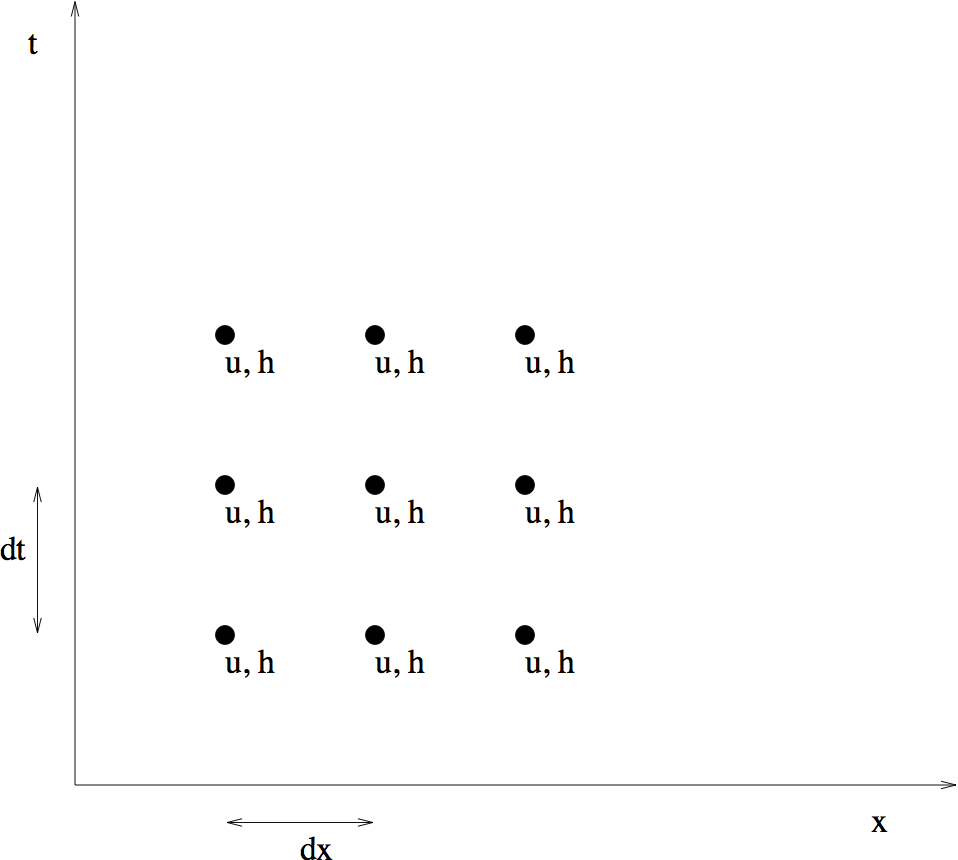

In [33]:
Image(filename='images/nonstagger.png',width='40%') 

<div id='lab7:fig:nonstagger'>
**Figure Unstaggered Grid.**
</div>

We will use centred difference schemes in both $x$ and $t$. The
equations become:
<div id='lab7:eq:nonstaggerGrid1'>
(Non-staggered, Eqn One)
$$\frac {u(t+dt, x)-u(t-dt, x)}{2 dt} + g \frac {h(t, x+dx) - h(t, x-dx)}{2dx} = 0$$
</div><div id='lab7:eq:nonstaggerGrid2'>
(Non-staggered, Eqn Two)
$$\frac {h(t+dt, x)-h(t-dt, x)}{2 dt} + H \frac {u(t, x+dx) - u(t, x-dx)}{2dx} = 0$$
</div>
We can rearrange these equations to
give $u(t+dt, x)$ and $h(t+dt, x)$. For a small number of points, the
resulting problem is simple enough to solve in a notebook.

For a specific example, consider a dish, 40 cm long, of water 1 cm deep.
Although the numerical code presented later allows you to vary the
number of grid points, in the discussion here we will use only 5 spatial
points, a distance of 10 cm apart. The lack of spatial resolution means
the wave will have a triangular shape. At $t=0$ a large drop of water
lands in the centre of the dish. So at $t=0$, all points have zero
velocity and zero elevation except at $x=3dx$, where we have
$$h(0, 3dx) = h_{0} = 0.01 cm$$

A centred difference scheme in time, such as defined by equations
([Non-staggered, Eqn One](#lab7:eq:nonstaggerGrid1)) and ([Non-staggered, Eqn Two](#lab7:eq:nonstaggerGrid2)), is
usually refered to as a *Leap frog scheme*. The new values, $h(t+dt)$
and $u(t+dt)$ are equal to values two time steps back $h(t-dt)$ and
$u(t-dt)$ plus a correction based on values calculated one time step
back. Hence the time scheme “leap-frogs” ahead. More on the consequences
of this process can be found in section [8.4 Computational Mode](#8.4-Computational-Mode).

As a leap-frog scheme requires two previous time steps, the given
conditions at $t=0$ are not sufficient to solve
([Non-staggered, Eqn One](#lab7:eq:nonstaggerGrid1)) and ([Non-staggered, Eqn Two](#lab7:eq:nonstaggerGrid2)). We
need the solutions at two time steps in order to step forward.

4.1 Predictor-Corrector to Start
----------------------------
[lab7:sec:pred-cor]:(#4.1-Predictor-Corrector-to-Start)

In section 4.2.2 of Lab 2, predictor-corrector methods were introduced.
We will use a predictor-corrector based on the forward Euler scheme, to
find the solution at the first time step, $t=dt$. Then the second order
scheme ([Non-staggered, Eqn One](#lab7:eq:nonstaggerGrid1)), ([Non-staggered, Eqn Two](#lab7:eq:nonstaggerGrid2)) can be used.

Using the forward Euler Scheme, the equations become
<div id='lab7:eq:newnonstaggerGrid1'>
$$\frac {u(t+dt, x)-u(t, x)}{dt} + g \frac {h(t, x+dx) - h(t, x-dx)}{2dx} = 0$$
</div><div id='lab7:eq:newnonstaggerGrid2'>
$$\frac {h(t+dt, x)-h(t, x)}{dt} + H \frac {u(t, x+dx) - u(t, x-dx)}{2dx} = 0$$
</div>

1.  Use this scheme to predict $u$ and $h$ at $t=dt$.

2.  Average the solution at $t=0$ and that predicted for $t=dt$, to
    estimate the solution at $t=\frac{1}{2}dt$. You should confirm that
    this procedure gives: $$u(\frac{dt}{2}) = \left\{ \begin{array}{ll}
    0 & { x = 3dx}\\
    \left({-gh_{0}dt}\right)/\left({4dx}\right) & { x = 2dx}\\
    \left({gh_{0}dt}\right)/\left({4dx}\right) & { x = 4dx}
    \end{array}
    \right.$$

    $$h(\frac{dt}{2}) = \left\{ \begin{array}{ll}
    h_{0} & { x = 3dx}\\
    0 & { x \not= 3dx}
    \end{array}
    \right.$$

3.  The corrector step uses the centred difference scheme in time (the
    leap-frog scheme) with a time step of ${dt}/{2}$ rather than dt. You
    should confirm that this procedure gives:
    $$u(dt) = \left\{ \begin{array}{ll}
    0 & { x = 3dx}\\
    \left({-gh_{0}dt}\right)/\left({2dx}\right) & { x = 2dx}\\
    \left({gh_{0}dt}\right)/\left({2dx}\right) & { x = 4dx}
    \end{array}
    \right.$$

    $$h(dt) = \left\{ \begin{array}{ll}
    0 & { x = 2dx, 4dx}\\
    h_{0} - \left({gHdt^2 h_{0}}\right)/\left({4dx^2}\right) & { x = 3dx}
    \end{array}
    \right.$$

Note that the values at $x=dx$ and $x=5dx$ have not been specified.
These are boundary points and to determine these values we must consider
the boundary conditions.

4.2 Boundary Conditions
-------------------

If we are considering a dish of water, the boundary conditions at
$x=dx, 5dx$ are those of a wall. There must be no flow through the wall.
$$u(dx) = 0$$ $$u(5dx) = 0$$ But these two conditions are not
sufficient; we also need $h$ at the walls. If $u=0$ at the wall for all
time then $\partial u/\partial t=0$ at the wall, so $\partial h/\partial x=0$ at the wall. Using a
one-sided difference scheme this gives
$$\frac {h(2dx) - h(dx)}{dx} = 0$$ or$$h(dx) = h(2dx)$$
and$$\frac {h(4dx) - h(5dx)}{dx} = 0$$ or$$h(5dx) = h(4dx)$$ which gives
the required boundary conditions on $h$ at the wall.

4.3 Simple Equations on a Non-staggered Grid
----------------------------------------

1.  Given the above equations and boundary conditions, we can find the
    values of $u$ and $h$ at all 5 points when $t = 0$ and $t = dt$.

2.  From ([Non-staggered, Eqn One](#lab7:eq:nonstaggerGrid1)) and ([Non-staggered, Eqn Two](#lab7:eq:nonstaggerGrid2)), we can find the values of $u$ and
    $h$ for $t = 2dt$ using $u(0, x)$, $u(dt, x)$, $h(0, x)$, and
    $h(dt, x)$.

3.  Then we can find the values of $u$ and $h$ at $t = 3dt$ using
    $u(dt, x)$, $u(2dt, x)$, $h(dt, x)$, and $h(2dt, x)$.

We can use this approach recursively to determine the values of $u$ and
$h$ at any time $t = n * dt$. The python code that solves this problem
is provided in the file rain.py. It takes two arguments, the first is the
number of time steps and the second is the number of horizontal grid
points. 

The output is two coloured graphs.  The color represents time with black
the earliest times and red later times.  The upper plot shows the water
velocity (u) and the lower plot shows the water surface.  To start with
the velocity is 0 (black line at zero across the whole domain) and the
water surface is up at the mid point and zero at all other points (black
line up at midpoint and zero elsewhere)

Not much happens in 6 time-steps.  Do try longer and more grid points.

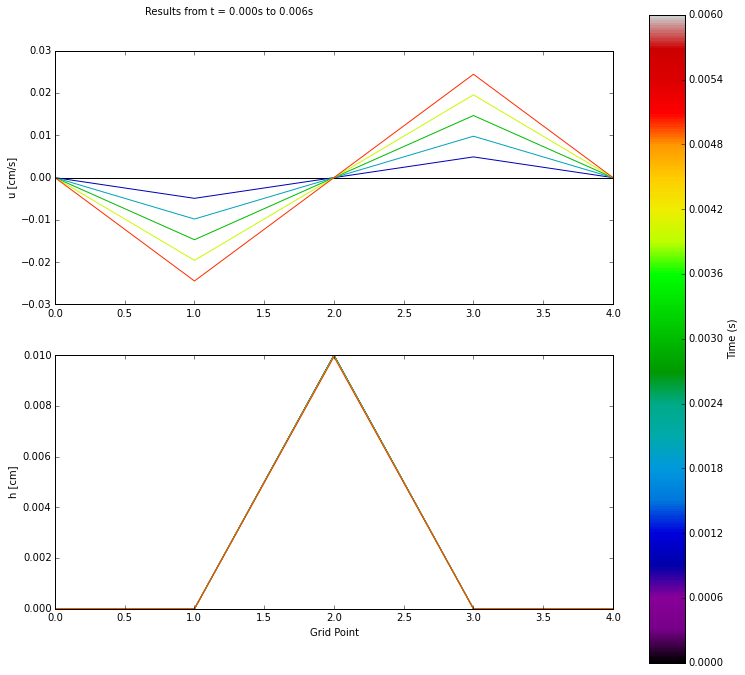

In [34]:
rain.rain([6, 5])

If you want to change something in the script (say the colormap I've chosen, spectral, doesn't work for you), you can edit rain.py in an editor or spyder.  To make it take effect here though, you have to reload rain.  See next cell for how to.  You will also need to do this if you do problem one or other tests by changing rain.py but running in a notebook.

In [35]:
import importlib
importlib.reload(rain)

<module 'numlabs.lab7.rain' from '/Users/alena/Sync/numeric/numlabs/lab7/rain.py'>

4.4 Staggered Grids
---------------
[lab7:sec:staggered]:(#4.4-Staggered-Grids)

After running the program with different numbers of spatial points, you
will discover that the values of $u$ are always zero at the odd numbered
points, and that the values of $h$ are always zero at the even numbered
points. In other words, the values of $u$ and $h$ are zero in every
other column starting from $u(t, dx)$ and $h(t, 2dx)$, respectively.

A look at ([Non-staggered, Eqn One](#lab7:eq:nonstaggerGrid1)) and ([Non-staggered, Eqn Two](#lab7:eq:nonstaggerGrid2)) can help us understand why this is the
case:

$u(t + dt, x)$ is dependent on $h(t , x + dx)$ and $h(t , x - dx)$,

but $h(t , x + dx)$ is in turn dependent on $u$ at $x + 2dx$ and at
$x$,

and $h(t , x - dx)$ is in turn dependent on $u$ at $x - 2dx$ and at
$x$.

Thus, if we just look at $u$ at a particular $x$, $u(x)$ will depend on
$u(x + 2dx)$, $u(x - 2dx)$, $u(x + 4dx)$, $u(x - 4dx)$, $u(x + 6dx)$,
$u(x - 6dx),$ ... but not on $u(x + dx)$ or $u(x - dx)$. Therefore, the
problem is actually decoupled and consists of two independent problems:
one problem for all the $u$’s at odd numbered points and all the $h$’s
at even numbered points, and the other problem for all the $u$’s at even
numbered points and all the $h$’s at odd numbered points, as shown in
Figure [Unstaggered Dependency](#lab7:fig:dependency).

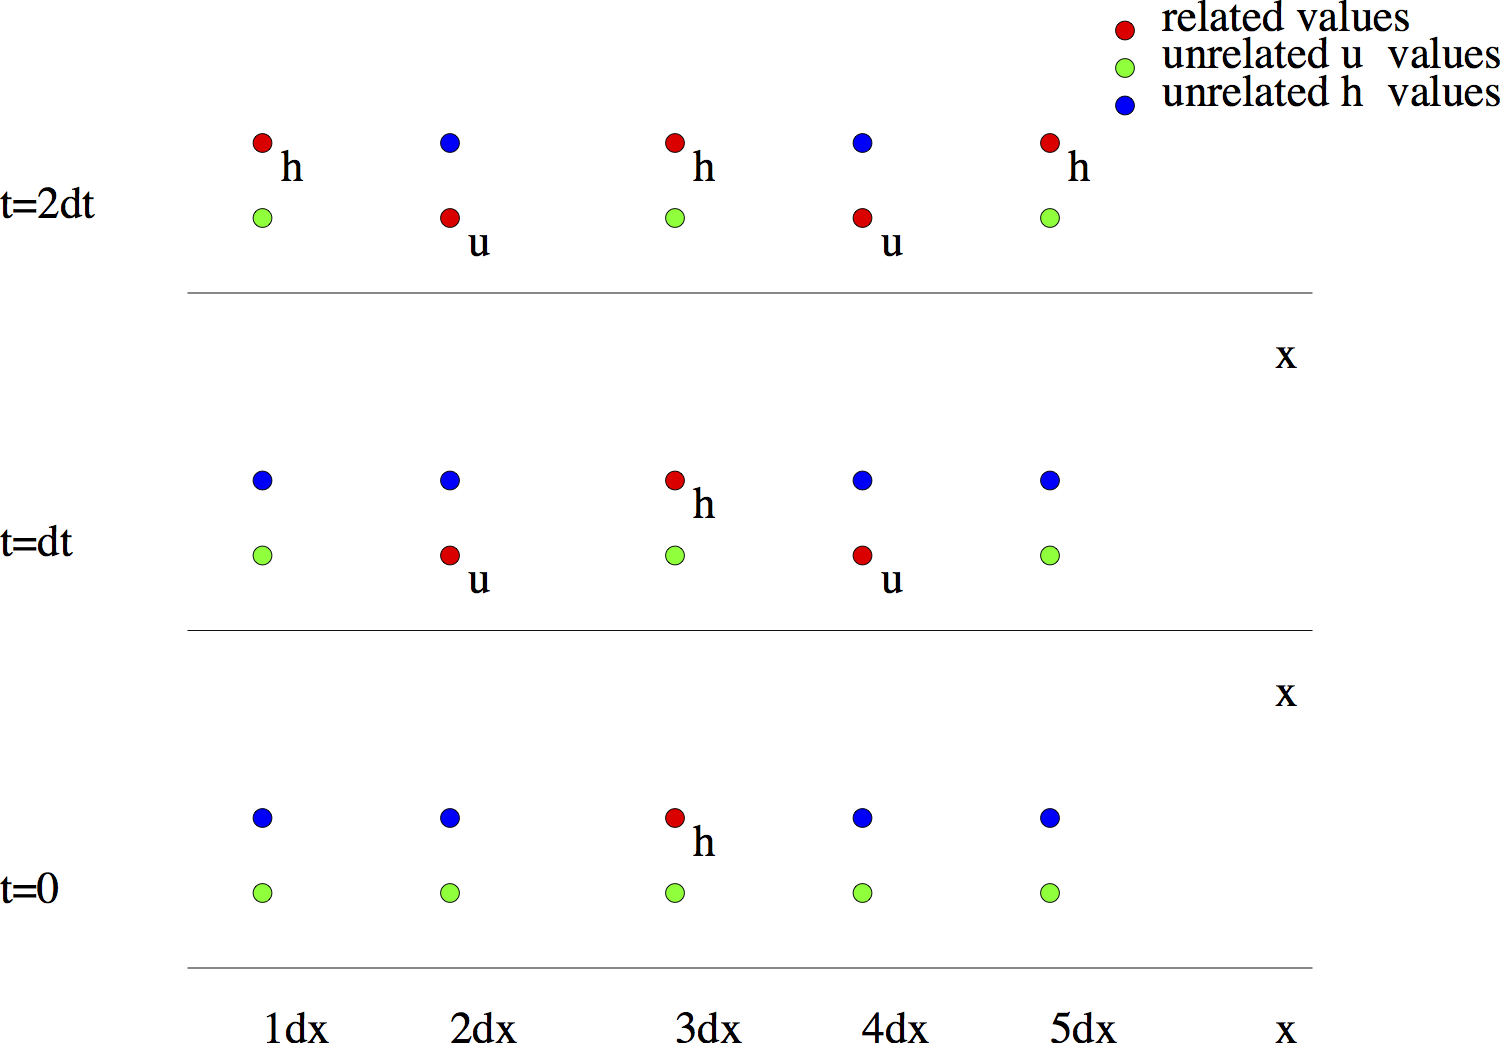

In [36]:
Image(filename='images/dependency.png',width='50%') 

<div id='lab7:fig:dependency'>
**Figure Unstaggered Dependency**
</div>

In either problem, only the variable that is relevant to that problem
will be considered at each point. So for one problem, if at point $x$ we
consider the $u$ variable, at $x + dx$ and $x -dx$ we consider $h$. In
the other problem, at the same point $x$, we consider the variable $h$.

Now we can see why every second $u$ point and $h$ point are zero for
*rain*. We start with all of
$u(dx), h(2dx), u(3dx), h(4dx), u(5dx) = 0$, which means they remain at
zero.

Since the original problem can be decoupled, we can solve for $u$ and
$h$ on each decoupled grid separately. But why solve two problems?
Instead, we solve for $u$ and $h$ on a single staggered grid; whereas
before we solved for $u$ and $h$ on the complete, non-staggered grid.
Figure [Decoupling](#lab7:fig:decoupling) shows the decoupling of the grids.

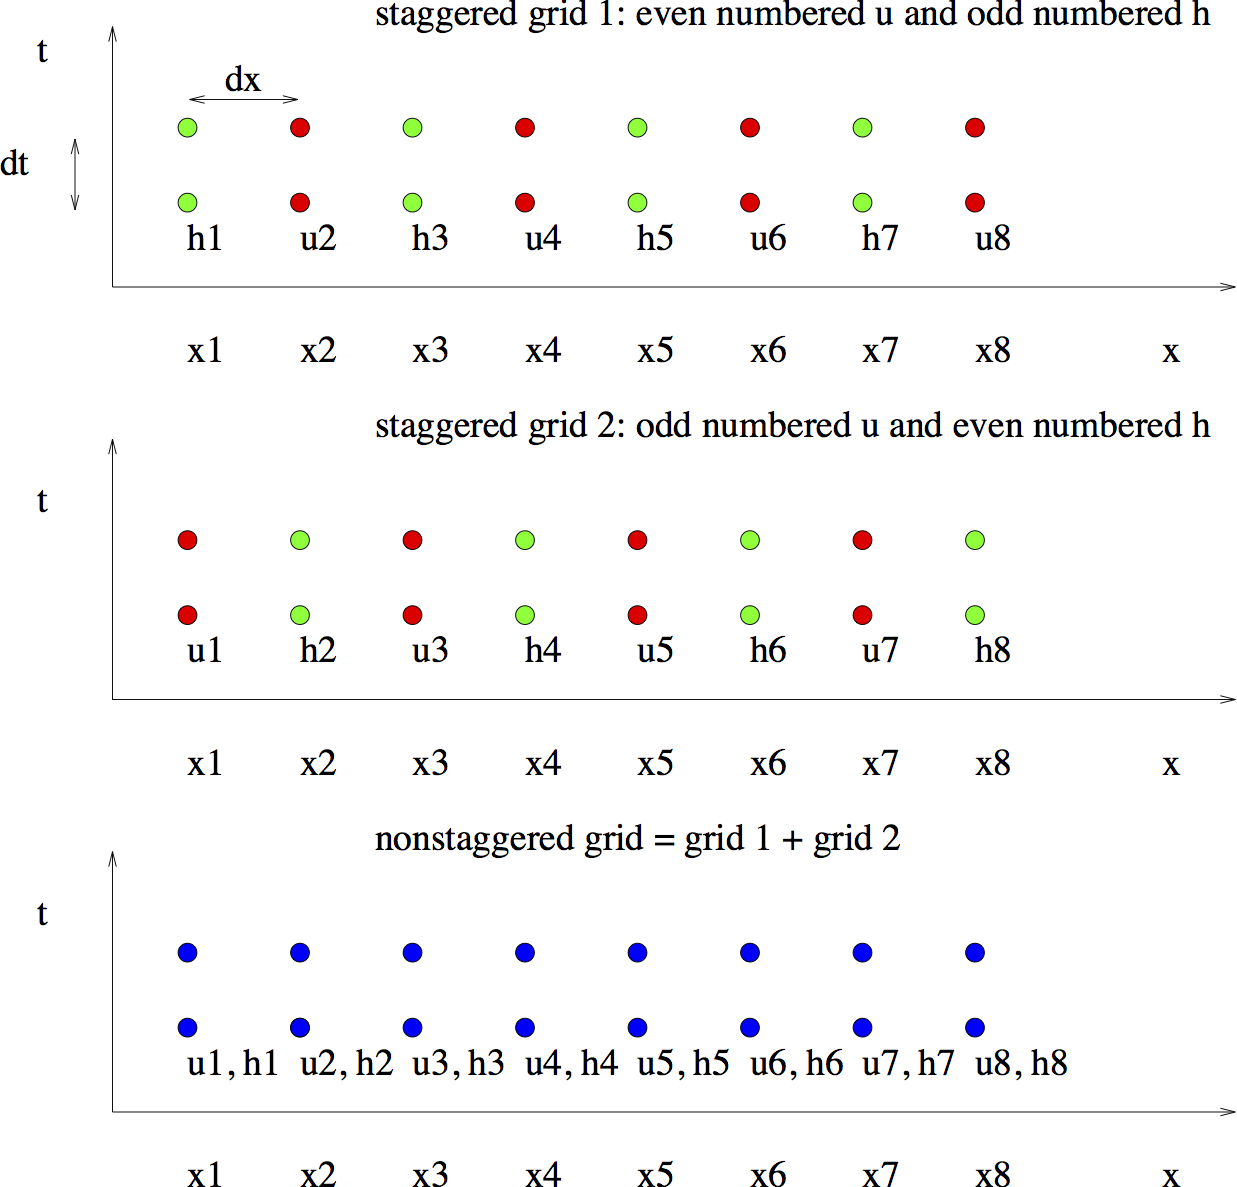

In [37]:
Image(filename='images/decoupling.png',width='50%') 

<div id='lab7:fig:decoupling'>
**Figure Decoupling**: The two staggered grids and the unstaggered grid. Note that the
unstaggered grid has two variables at each grid/time point whereas the
staggered grids only have one.
</div>

Now consider the solution of the same problem on a staggered grid. The
set-up of the problem is slightly different this time; we are
considering 4 spatial points in our discussion instead of 5, shown in
Figure [Staggered Grid](#lab7:fig:stagger). We will also be using $h_{i}$ and $u_{i}$ to
denote the spatial points instead of $x = dx * i$.

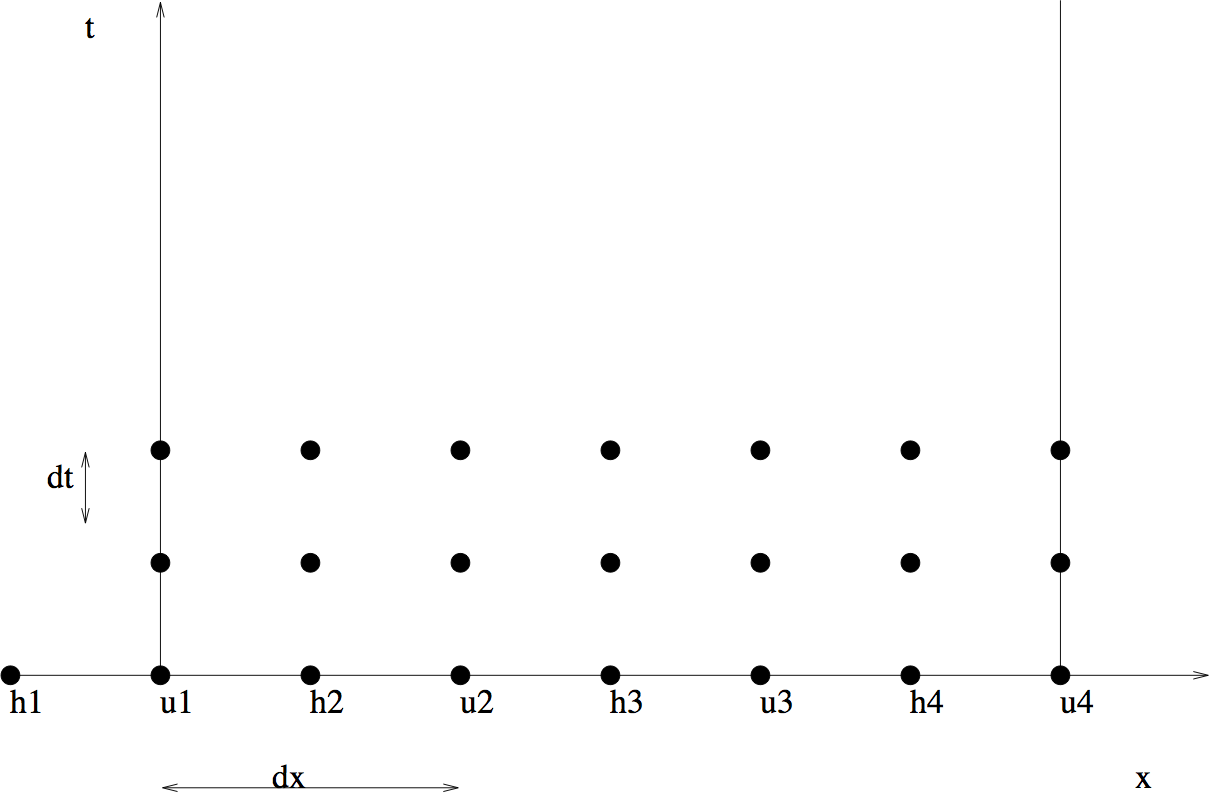

In [38]:
Image(filename='images/stagger.png',width='50%') 

<div id='lab7:fig:stagger'>
**Figure Staggered Grid**: The staggered grid for the drop in the pond problem.
</div>

The original equations, boundary and initial conditions are changed to
reflect the staggered case. The equations are changed to the following:
<div id='lab7:eq:staggerGrid1'>
(Staggered, Eqn 1)
$$\frac {u_{i}(t+dt)-u_{i}(t-dt)}{2 dt} + g \frac {h_{i + 1}(t) - h_{i}(t)}{dx} = 0$$
</div><div id='lab7:eq:staggerGrid2'>
(Staggered, Eqn 2)
$$\frac {h_{i}(t+dt)-h_{i}(t-dt)}{2 dt} + H \frac {u_{i}(t) - u_{i - 1}(t)}{dx} = 0$$
</div>

The initial conditions are: At $t = 0$ and $t = dt$, all points have
zero elevation except at $h_{3}$, where $$h_{3}(0) = h_{0}$$
$$h_{3}(dt) = h_{3}(0) - h_{0} Hg \frac{dt^2}{dx^2}$$ At $t = 0$ and
$t = dt$, all points have zero velocity except at $u_{2}$ and $u_{3}$,
where $$u_{2}(dt) = - h_{0} g \frac{dt}{dx}$$
$$u_{3}(dt) = - u_{2}(dt)$$ This time we assume there is a wall at
$u_{1}$ and $u_{4}$, so we will ignore the value of $h_{1}$. The
boundary conditions are: $$u_{1}(t) = 0$$ $$u_{4}(t) = 0$$

*Problem One*
------------
[lab7:prob:staggered]:(#Problem-One) 
> Modify *rain.py* to solve this problem (Simple
equations on a staggered grid). Submit your code and a final plot for
one case.


5. Stability: the CFL condition
============================
[lab7:stability]:(#5.-Stability:-the-CFL-condition)

In the previous problem, $dt = 0.001s$ is used to find $u$ and $h$. If
you increase $dt$ by 100 times, and run *rain.py* on your staggered grid
code again, you can see that the magnitude of $u$ has increased from
around 0.04 to $10^8$! Try this by changing $ dt = 0.001 $ to
$ dt = 0.1 $ in the code and compare the values of $u$ when run with
different values of $dt$. This tells us that the scheme we have been
using so far is unstable for large values of $dt$.

To understand this instability, consider a spoked wagon wheel in an old
western movie (or a car wheel with a pattern in a modern TV movie) such
as that shown in Figure [Wheel](#lab7:fig:wheel-static).

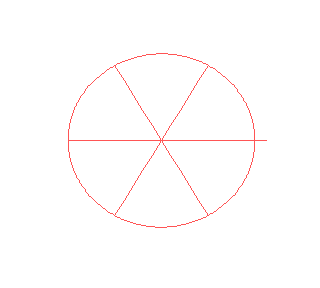

In [39]:
Image(filename='images/wheel_static.png',width='35%') 

<div id='lab7:fig:wheel-static'>
**Figure Wheel**: A spoked wagon wheel.
</div>

Sometimes the wheels appear to be going backwards. Both TV and
movies come in frames and are shown at something like 30 frames a second.
So a movie discretizes time. If the wheel moves just a little in the
time step between frames, your eye connects the old position with the
new position and the wheel moves forward $-$ a single frame is shown in
Figure [Wheel Left](#lab7:fig:wheel-left).

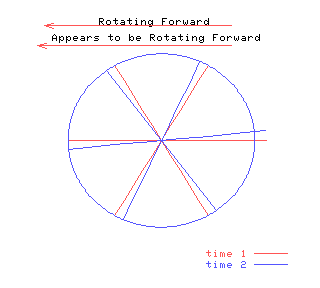

In [40]:
Image(filename='images/wheel_left.png',width='35%') 

<div id='lab7:fig:wheel-left'>
**Figure Wheel Left:** The wheel appears to rotate counter-clockwise if its speed is slow
enough.
</div>

In [41]:
import IPython.display as display
vid = display.YouTubeVideo("hgQ66frbBEs", modestbranding=1, rel=0, width=500)
display.display(vid)

However, if the wheel is moving faster, your eye connects each spoke
with the next spoke and the wheel seems to move backwards $-$ a single
frame is depicted in Figure [Wheel Right](#lab7:fig:wheel-right).

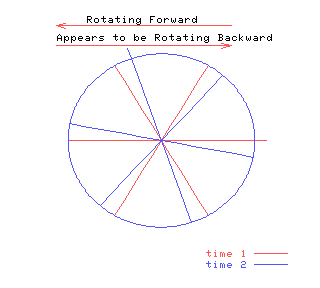

In [42]:
Image(filename='images/wheel_right.png',width='35%') 

<div id='lab7:fig:wheel-right'>
**Figure Wheel Right**: When the wheel spins quickly enough, it appears to rotate
clockwise!
</div>

In [43]:
vid = display.YouTubeVideo("w8iQIwX-ek8", modestbranding=1, rel=0, width=500)
display.display(vid)

In a similar manner, the time discretization of any wave must be small
enough that a given crest moves less than half a grid point in a time
step. Consider the wave pictured in Figure [Wave](#lab7:fig:wave-static).

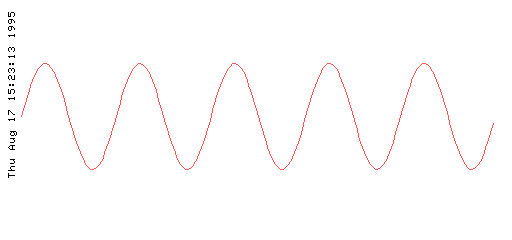

In [44]:
Image(filename='images/wave_static.png',width='65%') 

<div id='lab7:fig:wave-static'>
**Figure Wave**: A single frame of the wave.
</div>

If the wave moves slowly, it seems to move in the correct direction
(i.e. to the left), as shown in Figure [Wave Left](#lab7:fig:wave-left).

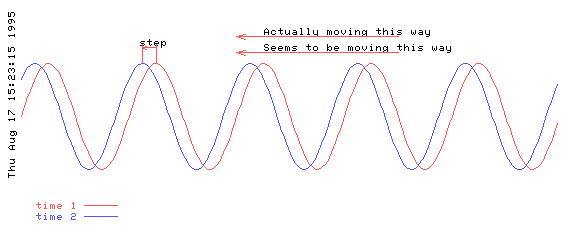

In [45]:
Image(filename='images/wave_left.png',width='65%') 

<div id='lab7:fig:wave-left'>
**Figure Wave Left**: The wave moving to the left also appears to be moving to the left if
it’s speed is slow enough.
</div>

In [46]:
vid = display.YouTubeVideo("CVybMbfYRXM", modestbranding=1, rel=0, width=500)
display.display(vid)

However if the wave moves quickly, it seems to move backward, as in
Figure [Wave Right](#lab7:fig:wave-right).

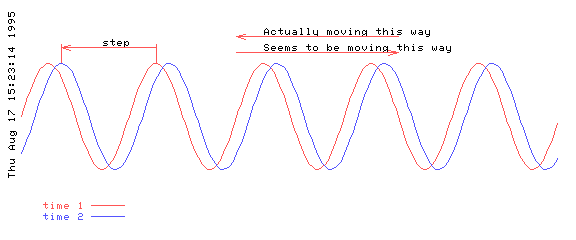

In [47]:
Image(filename='images/wave_right.png',width='65%') 

<a name='lab7:fig:wave-right'></a>
**Figure Wave Right**: If the wave moves too rapidly, then it appears to be moving in the
opposite direction.

In [48]:
vid = display.YouTubeVideo("al2VrnkYyD0", modestbranding=1, rel=0, width=500)
display.display(vid)

In summary, an explicit numerical scheme is unstable if the time step is
too large. Such a large time step does not resolve the process being
modelled. Now we need to calculate, for our problem, the maximum value
of the time step is for which the scheme remains stable. To do this
calculation we will derive the dispersion relation of the waves
*in* the numerical scheme. The maximum time step for
stability will be the maximum time step for which all waves either
maintain their magnitude or decay.

Mathematically, consider the equations ([Staggered, Eqn 1](#lab7:eq:staggerGrid1)) and
([Staggered, Eqn 2](#lab7:eq:staggerGrid2)). Let $x=md$ and $t=p\, dt$ and consider a
solution 
<div id='eq:udis'>
(u-solution)
$$\begin{aligned}
u_{mp} &=& {\cal R}e \{ {\cal U} \exp [i(kx - \omega t)] \}\\
&=& {\cal R}e \{ {\cal U} \exp [i(kmd - \omega p\, dt)] \} \nonumber\end{aligned}$$
$$\begin{aligned}
h_{mp} &=& {\cal R}e \{ {\cal H} \exp [i(k[x - dx/2] - \omega t)] \}\\
&=& {\cal R}e \{ {\cal H} \exp [i(k[m - 1/2]d - \omega p\, dt)] \} \nonumber\end{aligned}$$
where ${\cal R}e$ means take the real part and ${\cal U}$ and ${\cal H}$
are constants. Substitution into ([Staggered, Eqn 1](#lab7:eq:staggerGrid1)) and
([Staggered, Eqn 2](#lab7:eq:staggerGrid2)) gives two algebraic equations in ${\cal U}$
and ${\cal H}$ which can be written: 
$$\left[
\begin{array}{cc} - \sin(\omega dt)/ dt & 2 g \sin(kd/2)/d \\
2 H \sin(kd/2)/d &  -\sin(\omega \, dt)/ dt \\
\end{array}
\right]
\left[
\begin{array}{c} {\cal U}\\ {\cal H}\\ 
\end{array} \right]
= 0.$$ 
</div>
where $\exp(ikd)-\exp(-ikd)$ has been written $2 i \sin(kd)$ etc.
In order for there to be a non-trivial solution, the determinant of the
matrix must be zero. This determinant gives the dispersion relation
<div id='lab7:eq:numerDisp'>
(Numerical Dispersion Relation)
$$ \frac{\sin^2(\omega \, dt)}{dt^2} = 4 gH \frac {\sin^2(kd/2)}{d^2}$$
</div>
Which can be compared to the ([Analytic Dispersion Relation](#lab7:eq:disp)), the “real” dispersion
relation. In particular, if we decrease both the time step and the space
step, $dt \rightarrow 0$ and $d \rightarrow 0$, 
([Numerical Dispersion Relation](#lab7:eq:numerDisp))
approaches ([Analytic Dispersion Relation](#lab7:eq:disp)). The effect of just the discretization in
space can be found by letting just $dt \rightarrow 0$ which gives
<div id='lab7:eq:numerDispSpace'>
(Continuous Time, Discretized Space Dispersion Relation)
$$\omega^2 = 4 gH \frac {\sin^2(kd/2)}{d^2}$$
</div>

The “real” dispersion relation, ([Analytic Dispersion Relation](#lab7:eq:disp)), and the numerical
dispersion relation with continuous time,
([Continuous Time, Discretized Space Dispersion Relation](#lab7:eq:numerDispSpace)), both give $\omega^2$ positive and
therefore $\omega$ real. However, this is not necessarily true for the
numerical dispersion relation ([Numerical Dispersion Relation](#lab7:eq:numerDisp)). What does a
complex $\omega$ mean? Well, go back to ([u-solution](#eq:udis)). A complex
$\omega = a + ib$ gives $u \propto \exp(-iat)\exp(bt)$. The first
exponential is oscillatory (like a wave) but the second gives
exponential growth if $b$ is positive or exponential decay if $b$ is
negative. Obviously, for a stable solution we must have $b \le 0$. So,
using ([Numerical Dispersion Relation](#lab7:eq:numerDisp)) we must find $\omega$ and determine if it
is real.

Now, because ([Numerical Dispersion Relation](#lab7:eq:numerDisp)) is a transcendental equation, how
to determine $\omega$ is not obvious. The following works:

-   Re-expand $\sin(\omega\,dt)$ as
    $(\exp(i \omega\,dt)-\exp(-i\omega\,dt))/2i$.

-   Write $\exp(-i\omega\,dt)$ as $\lambda$ and note that this implies
    $\exp(i\omega\, dt) = 1/\lambda$. If $\omega dt = a + ib$ then
    $b =  ln |\lambda|$. For stability the magnitude of $\lambda$ must
    be less than one.

-   Write $4 gH \sin^2(kd/2)/d^2$ as $q^2$, for brevity.

-   Substitute in ([Numerical Dispersion Relation](#lab7:eq:numerDisp)) which gives:
    $$-(\lambda-1/\lambda)^2 = 4 q^2 dt^2$$ or
    $$\lambda^4 - 2 (1 - 2 q^2 dt^2) \lambda^2 + 1 = 0$$ or
    <div id='lab7:eq:lambda'>
    (Lambda Eqn)
    $$\lambda = \pm \left(1-2q^2 dt^2 \pm 2 q dt \left( q^2
        dt^2 - 1 \right)^{1/2} \right)^{1/2}$$ 
    </div>

A plot of the four roots for $\lambda$ is shown below in
Figure [Roots](#lab7:fig:allmag).

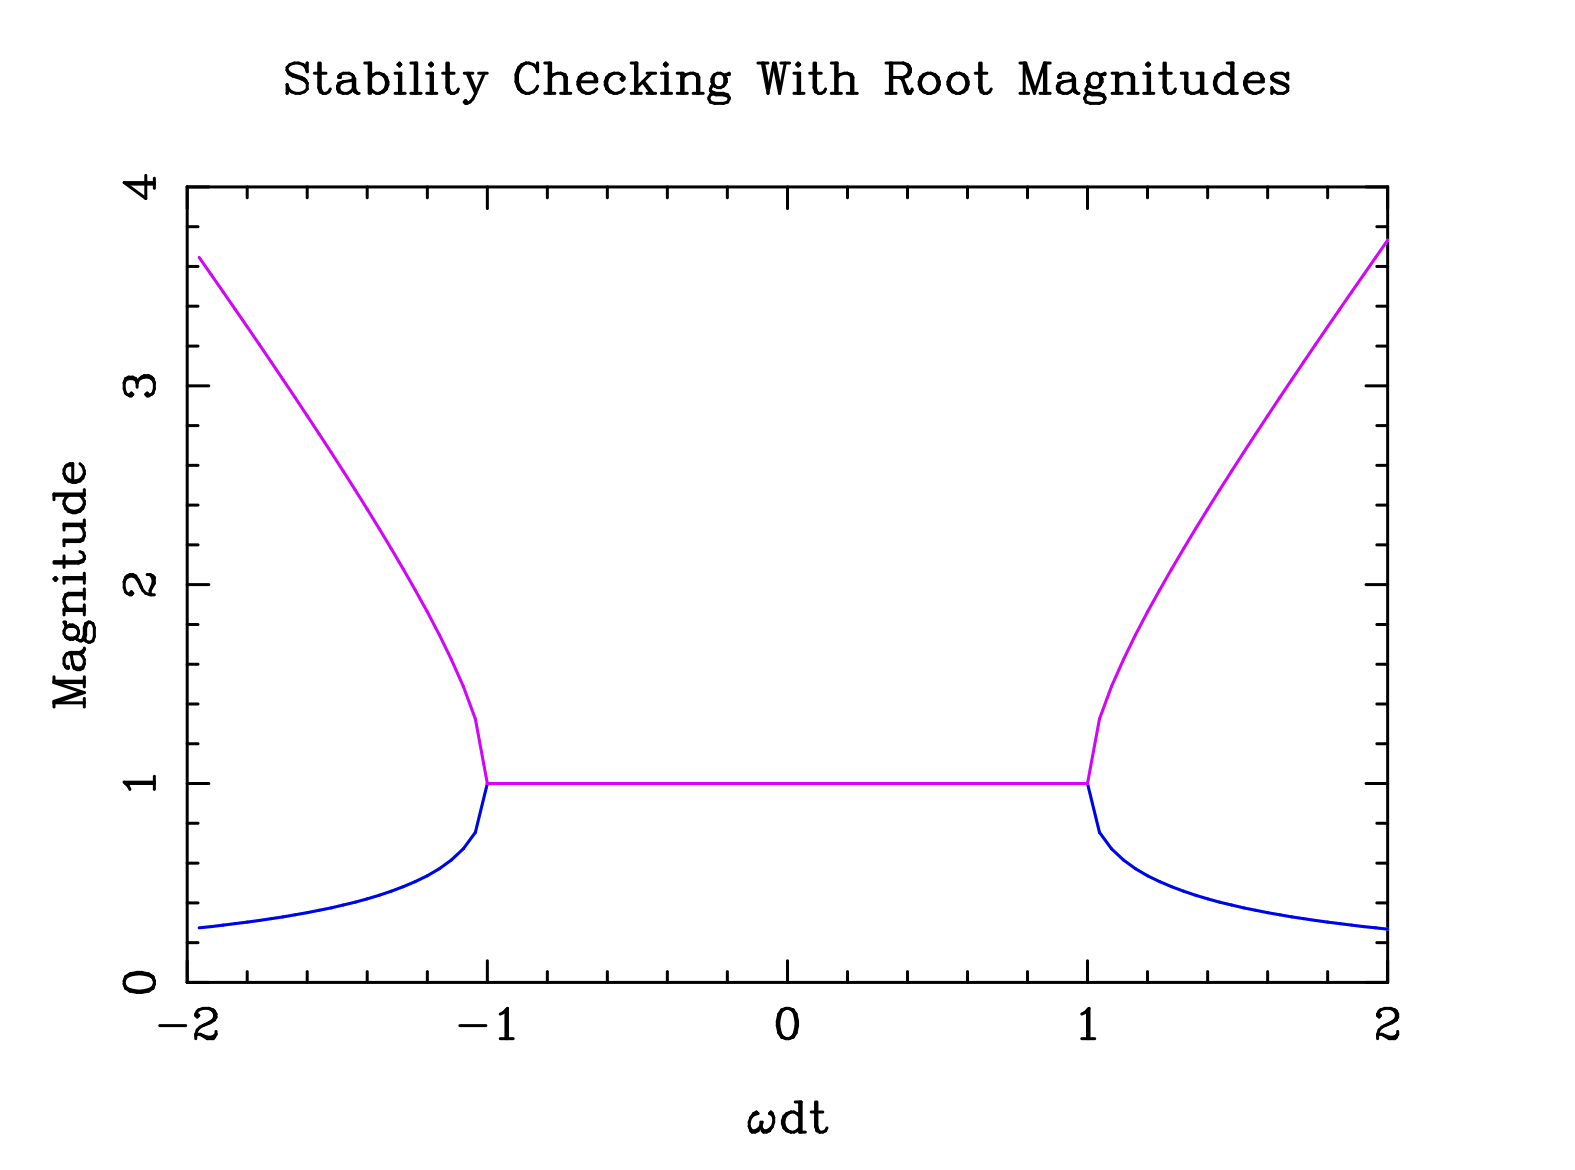

In [49]:
Image(filename='images/allmag.png',width='45%') 

<div id='lab7:fig:allmag'>
**Figure Roots**: Magnitude of the four roots of $\lambda$ as a function of $q dt$ (not
$\omega dt$).
</div>

The four roots correspond to the “real” waves travelling to the right
and left, as well two *computational modes* (see
Section [8.4 Computational Mode](#8.4-Computational-Mode) for more information). The plots for
the four roots overlap, so it is most helpful to view [separate plots for each of the roots](#lab7:fig:allmag). 

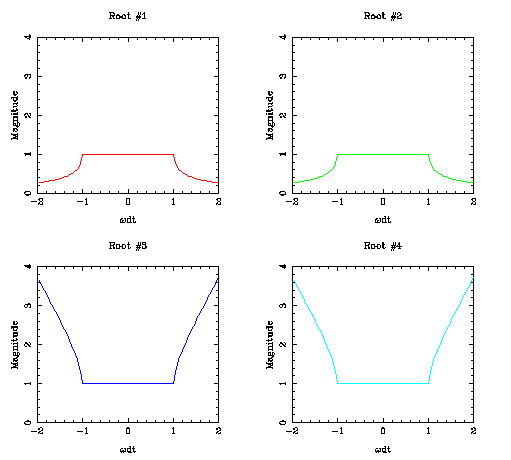

In [50]:
Image(filename='images/multimag.png',width='60%') 

<div id='lab7:fig:allmag'>
**Figure Separate Roots**: Magnitude of the four roots of $\lambda$ as a function of $q dt$ (not $\omega dt$).
</div>

Now for stability
$\lambda$ must have a magnitude less than or equal to one. From
Figure [Roots](#lab7:fig:allmag), it is easy to see that this is the same as
requiring that $|q dt|$ be less than 1.0.

Substituting for $q$
$$1 > q^2 dt^2 =  \frac {4gH}{d^2} \sin^2(kd/2) dt^2$$ for all $k$.

The maximum wavenumber that can be resolved by a grid of size $d$ is
$k = \pi/d$. At this wavenumber, the sine takes its maximum value of 1.
So the time step 
<div id='lab7:eq:dt'>
$$dt^2 < \frac { d^2}{4 g H}$$
</div>

For this case ($f = 0$) the ratio of the space step to the time step
must be greater than the wave speed $\sqrt
{gH}$, or $$d / dt > 2  \sqrt{gH}.$$ This stability condition is known
as **the CFL condition** (named after Courant, Friedrich and Levy).

On a historical note, the first attempts at weather prediction were
organized by Richardson using a room full of human calculators. Each
person was responsible for one grid point and passed their values to
neighbouring grid points. The exercise failed dismally, and until the
theory of CFL, the exact reason was unknown. The equations Richardson
used included fast sound waves, so the CFL condition was
$$d/dt > 2 \times 300 {\rm m/s}.$$ Richardson’s spatial step, $d$, was
too small compared to $dt$ and the problem was unstable.

*Problem Two*
-------------
[lab7:prob:stability]:(#Problem-Two)
> a) Find the CFL condition (in seconds) for $dt$
for the Python example in Problem One.
<!--- [lab7:prob:staggered]---> Test your
value. 

> b) Find the CFL condition (in seconds) for $dt$ for the Python
example in *rain.py*, ie., for the non-staggered grid. Test your value.


6. Accuracy
========
[lab7:accuracy]:(#6.-Accuracy)

A strong method to determine the accuracy of a scheme is to compare the
numerical solution to an analytic solution. The equations we are
considering are wave equations and so we will compare the properties of
the waves. Wave properties are determined by the dispersion relation and
we will compare the *numerical dispersion relation* and the exact, continuous
*analytic dispersion relation*. Both the time step and the space step
(and as we’ll see below the grid) affect the accuracy. Here we will only
consider the effect of the space step. So, consider the numerical
dispersion relation assuming $dt \rightarrow 0$ (reproduced here from
([Continuous Time, Discretized Space Dispersion Relation](#lab7:eq:numerDispSpace)))
$$\omega^2 = 4 gH \frac {\sin^2(kd/2)}{d^2}$$ with the exact, continuous
dispersion relation ([Analytic Dispersion Relation](#lab7:eq:disp)) $$\omega^2 = gHk^2$$

We can plot the two dispersion relations as functions of $kd$, The graph
is shown in Figure [Simple Accuracy](#lab7:fig:simpleaccuracy).

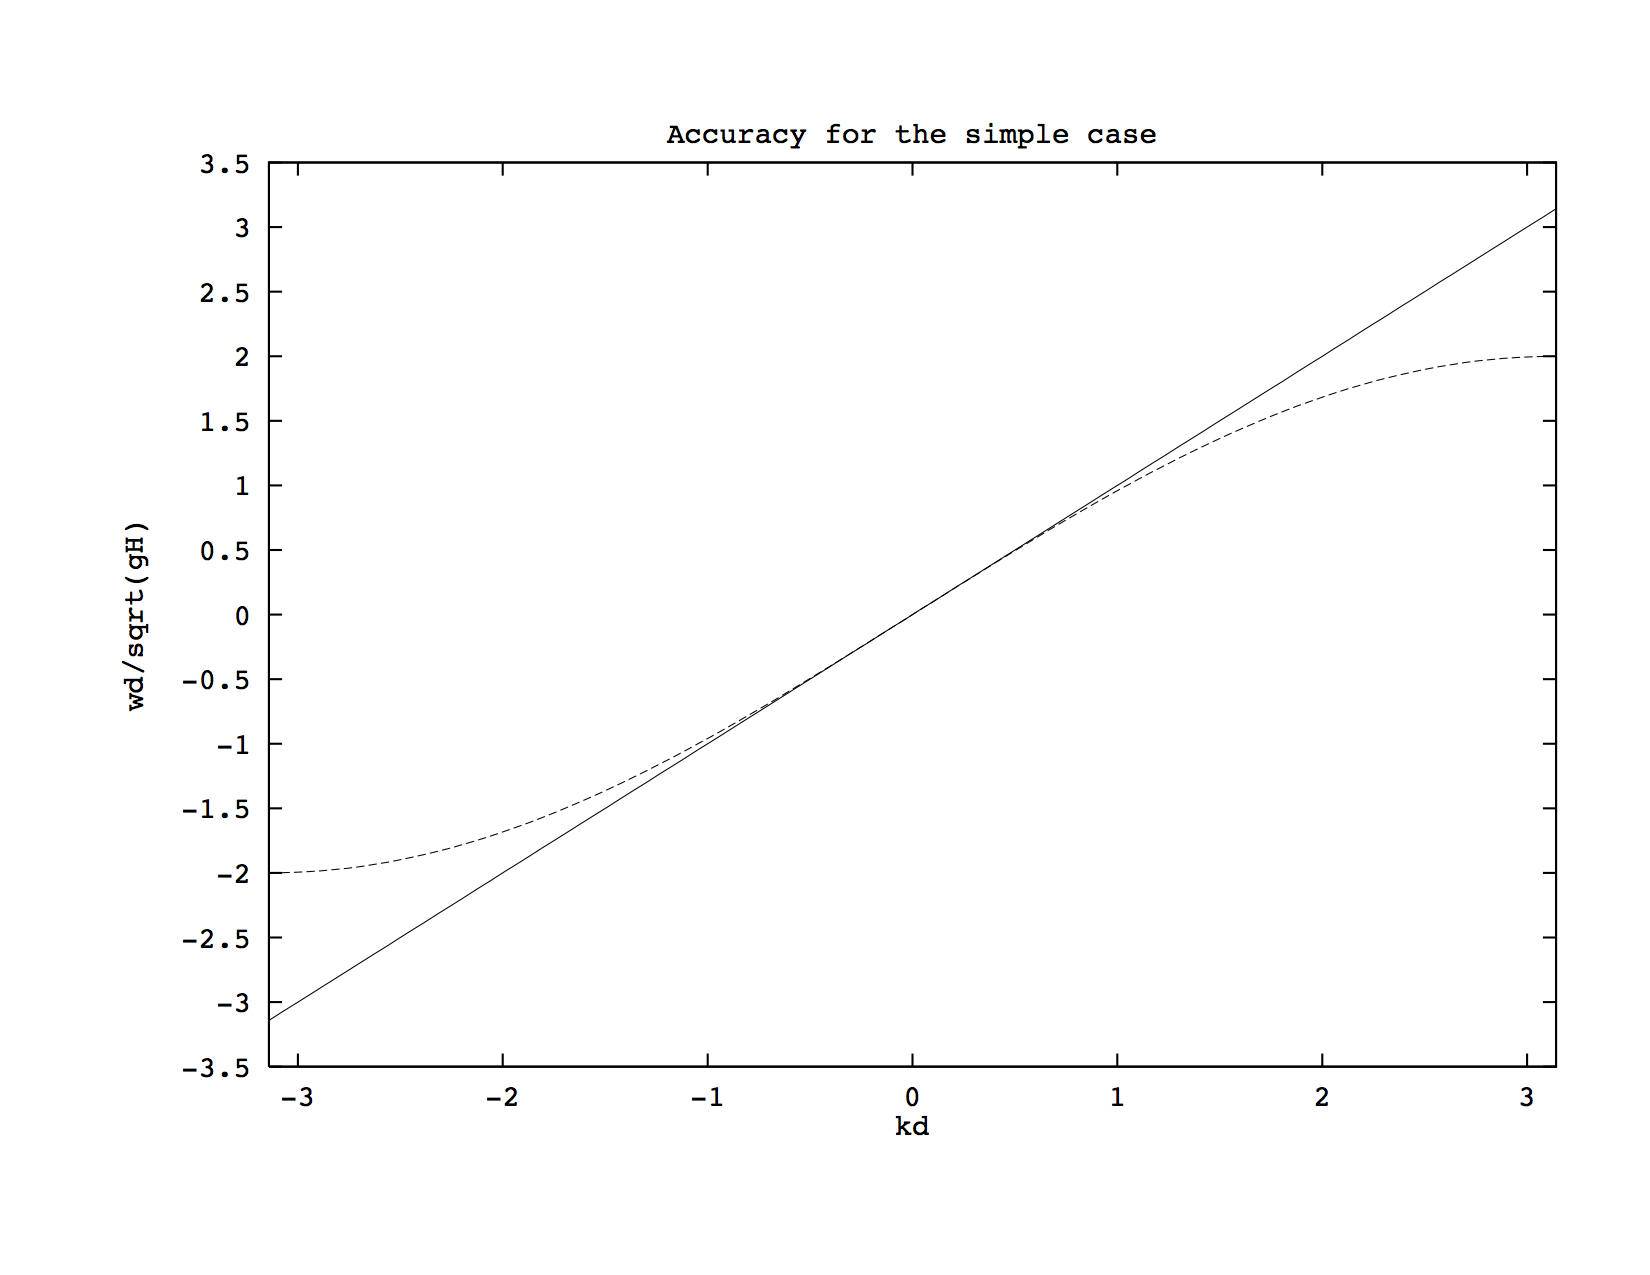

In [51]:
Image(filename='images/simple_accuracy.png',width='50%') 

<div id='lab7:fig:simpleaccuracy'>
**Figure Simple Accuracy**
</div>

We can see that the accuracy is good for long waves ($k$ small) but for
short waves, near the limit of the grid resolutions, the discrete
frequency is too small. As the phase speed is ${\omega}/{k}$, the phase
speed is also too small and most worrying, the group speed
${\partial \omega}/
{\partial k}$ goes to zero!

6.1 Choosing a Grid
---------------

### No variation in y
[no-variation-in-y-2.unnumbered]:(#No-variation-in-y)

For the simple case above, there is little choice in grid. Let’s
consider the more complicated case, $f \not = 0$. Then $v \not = 0$ and
we have to choose where on the grid we wish to put $v$. There are two
choices:

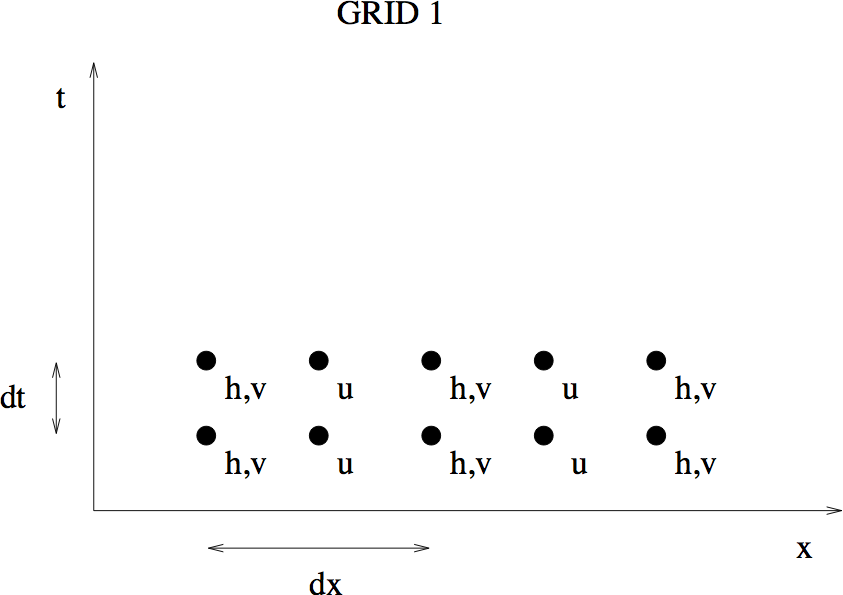

In [52]:
Image(filename='images/simple_grid1.png',width='50%') 

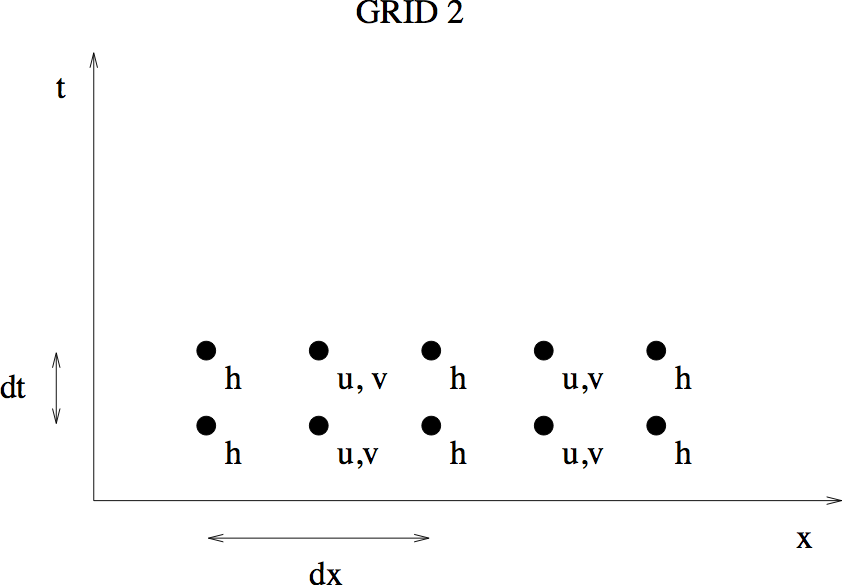

In [53]:
Image(filename='images/simple_grid2.png',width='50%') 

<div id='lab7:fig:simplegrids'>
**Figure Two Simple Grids**
</div>

For each of these, we can calculate the discrete dispersion relation
discussed above.

For grid 1
$$\omega ^2 = f^2 \cos^2(\frac{kd}{2}) + \frac{4gH \sin^2(\frac{kd}{2})}{d^2}$$

*Problem Three*
--------------
[lab7:prob:grid2]:(#Problem-Three)
> Show that for grid 2
$$\omega ^2 = f^2  + \frac{4gH \sin^2(\frac{kd}{2})}{d^2}$$

We can plot the two dispersion relations as a function of $k$ given the
ratio of $d/R$, where $d$ is the grid size and $R$ is the Rossby radius
which is given by $$R = \frac {\sqrt{gH}}{f}.$$

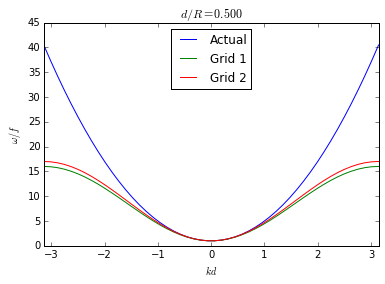

In [54]:
accuracy2d.main(0.5)

*Problem Four*
--------------
[lab7:prob:accurate]:(#Problem-Four) 
> Which grid gives the best accuracy for $d=R/2$?
Explain in what ways it is more accurate.

*Problem Five*
-------------
[lab7:prob:noy]:(#Problem-Five)
> Modify *rain.py* to solve equations
([No variation in y, first eqn](#lab7:sec:firsteq)), ([No variation in y, second eqn](#lab7:sec:secondeq)) and ([No variation in y, third eqn](#lab7:sec:thirdeq)) on the most accurate
grid.

7. Full Equations
==============
[sec:full]:(#7.-Full-Equations)

In order to solve the full equations
([Full Equations, Eqn 1](#lab7:eq:swea])), ([Full Equations, Eqn 2](#lab7:eq:sweb)) and ([Full Equations, Eqn 3](#lab7:eq:swec)) numerically, we need to
discretize in 3 dimensions, two in space and one in time.
 [Mesinger and Arakawa, 1976](#Ref:MesingerArakawa) introduced [five different spatial discretizations](#http://clouds.eos.ubc.ca/ phil/numeric/labs/lab7/images/allgrid.gif).
 
 
Consider first the most obvious choice an
unstaggered grid or Arakawa A grid, shown in Figure [Arakawa A Grid](#lab7:fig:gridA). We
might expect, from the studies above, that an unstaggered grid may not
be the best choice. The grid A is not two de-coupled grids because of
weak coupling through the Coriolis force. However, we will see that this
grid is not as accurate as some of the staggered grids (B, C, D and E).

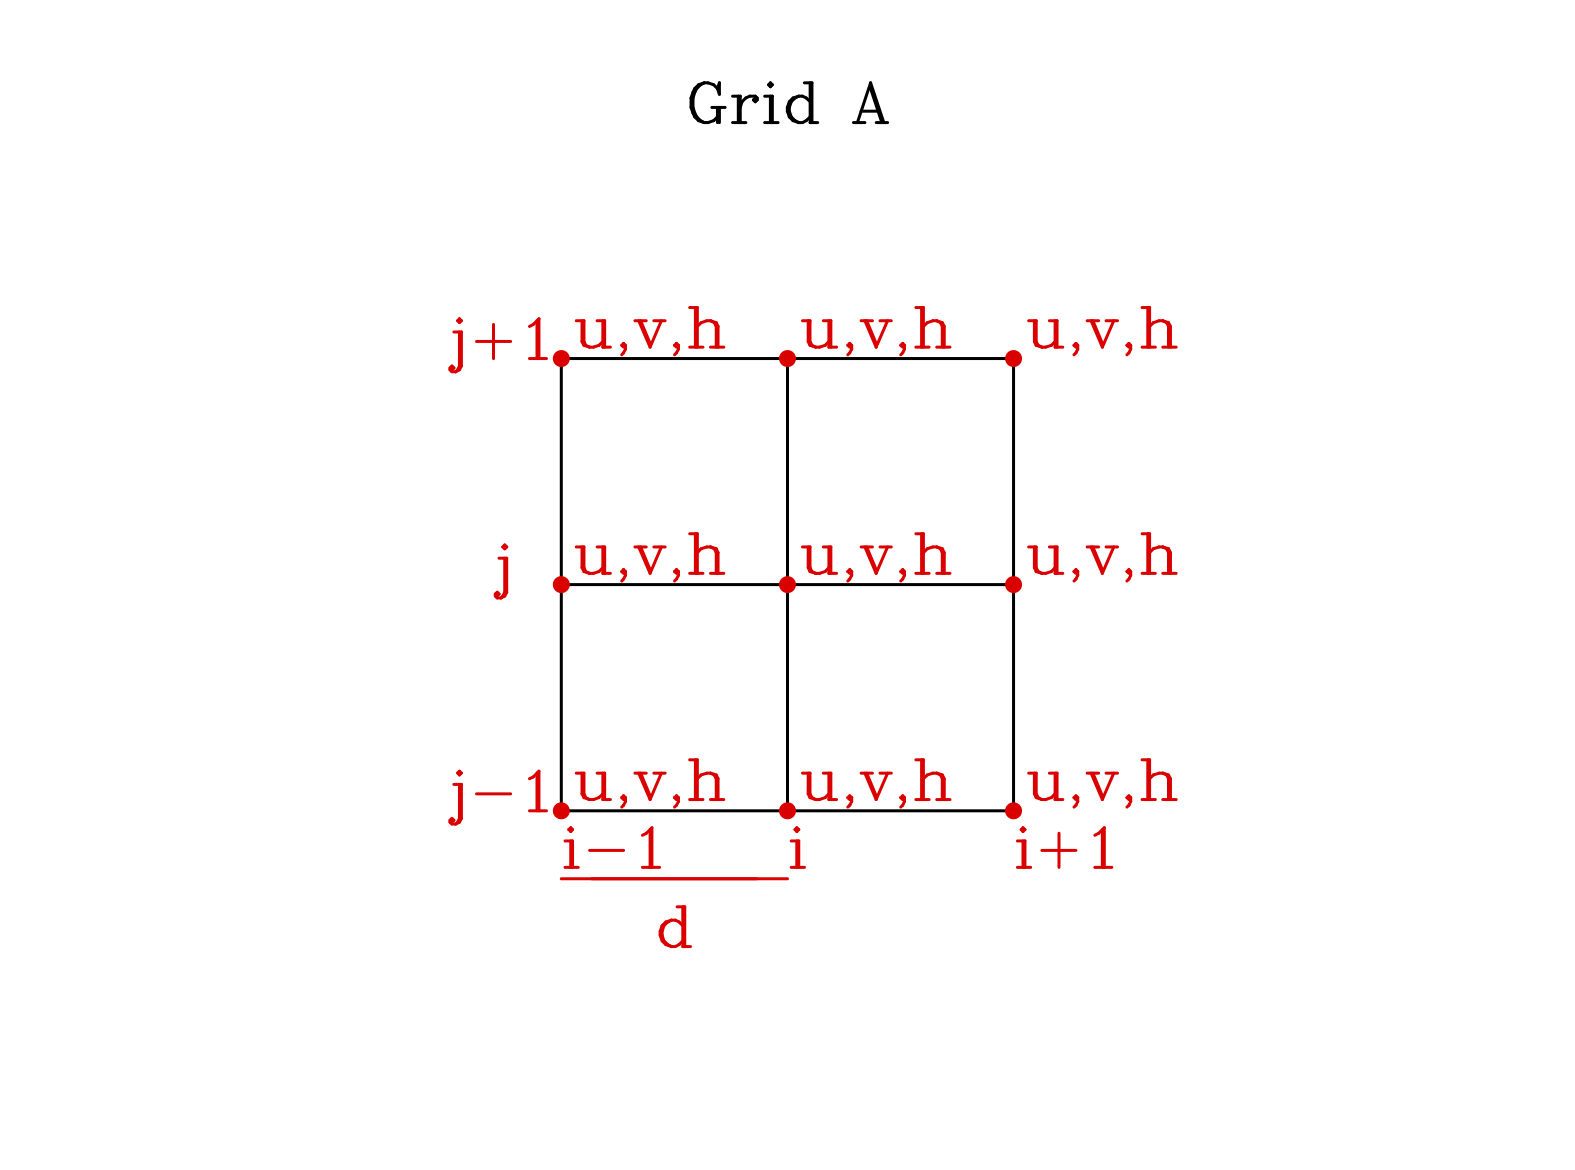

In [55]:
Image(filename='images/grid1.png',width='50%') 

<div id='lab7:fig:gridA'>
**Figure Arakawa A Grid.**
</div>

As the problem becomes more complicated, we need to simplify the
notation; hence define a discretization operator:
$$(\delta_x \alpha)_{(m,n)} \equiv \frac 1 {2d} ( \alpha_{m+1,n} - \alpha_{m-1,n} )
$$ 

where $d$ is the grid spacing in both the $x$ and
$y$ directions. Note that this discretization is the same centered
difference we have used throughout this lab.

The finite difference approximation to the full shallow water equations
on the A grid becomes: 
$$\frac{\partial u}{\partial t} = -g \delta_x h + fv$$
$$\frac{\partial v}{\partial t} = -g \delta_y h - fu$$ 
$$\frac{\partial h}{\partial t} = -H (\delta_x u + \delta_y v)$$
As before, consider a centre difference scheme (leap-frog method) for
the time step as well, so that
$$\frac{\partial u}{\partial t}(t) = \frac {u(t+1)-u(t-1)}{2 dt}$$ Putting this together with
the spatial scheme we have:
$$\frac {u(t+1)-u(t-1)}{2 dt} = -g \delta_x h(t) + fv(t)$$
$$\frac{v(t+1)-v(t-1)}{2 dt} = -g \delta_y h(t) - fu(t)$$
$$\frac{h(t+1)-h(t-1)}{2 dt} = -H (\delta_x u(t) + \delta_y v(t))$$ Each
of these equations can be rearranged to give $u(t+1)$, $v(t+1)$ and
$h(t+1)$, respectively. Then given the values of the three variables at
every grid point at two times, ($t$ and $t-1$), these three equations
allow you to calculate the updated values, the values of the variables
at $t+1$. Once again, the following questions arise regarding the
scheme:

-   **Is it stable?**

-   **Is it accurate?**

7.1 Stability
---------

To determine the stability of the scheme, we need to repeat the analysis
of section [5. Stability](#5.-Stability:-the-CFL-condition) for the 2 spatial dimensions used here. The
first step is to assume a form of the solutions: 
<div id='eq:zdis'>
$$\begin{aligned}
z_{mnp} &=& {\cal R}e \{ {\cal Z} \exp [i(kx + \ell y - \omega t)] \}\\
&=& {\cal R}e \{ {\cal Z} \exp [i(kmd + \ell n d- \omega p\, dt)] \} \nonumber\end{aligned}$$
</div>
where $z$ represents any of $u$, $v$ and $h$ and we have let $x=md$,
$y=nd$ and $t=p\,dt$. Substitution gives three algebraic equation in
${\cal U}$, ${\cal V}$ and ${\cal H}$: $$\left[
\begin{array}{ccc} - i \sin(\omega dt)/ dt & - f & i g \sin(kd)/d \\
f & - i \sin(\omega dt)/ dt & i g \sin(\ell d)/d \\
i H \sin(kd)/d &  i H \sin(\ell d)/d &  -i \sin(\omega \, dt)/ dt \\
\end{array}
\right]
\left[
\begin{array}{c} {\cal U}\\ {\cal V} \\ {\cal H}\\ 
\end{array} \right]
= 0.$$

Setting the determinate to zero gives the dispersion relation:
<div id='lab7:eq:full:numDisp'>
(Full Numerical Dispersion Relation)
$$
\frac {\sin^2(\omega\,dt)}{dt^2} = f^2 + \frac{gH}{d^2} \left( \sin^2(kd) + \sin^2(\ell d) \right)$$
</div>
Still following section [5. Stability](#5.-Stability:-the-CFL-condition), let
$\lambda = \exp (i \omega\, dt)$ and let
$q^2 = f^2 + {gH}/{d^2} \left( \sin^2(kd) + \sin^2(\ell d) \right)$,
substitution into ([Full Numerical Dispersion Relation](#lab7:eq:full:numDisp)) gives
$$-(\lambda-1/\lambda)^2 = 4 q^2 dt^2$$ or equation ([Lambda Eqn](#lab7:eq:lambda))
again. For stability $\lambda$ must be less than 1, so
$$1 > q^2 dt^2 = {dt^2} \left(f^2 + {gH}/{d^2} \left( \sin^2(kd) + \sin^2(\ell d) \right)
\right)$$ The sines take their maximum values at $k=\pi/(2d)$ and
$\ell=\pi/(2d)$ giving $$dt^2 < \frac{1}{f^2 + 2 gH/d^2}$$ This is the
CFL condition for the full equations on the Arakawa A grid. Note that
the most unstable mode moves at $45^o$ to the grid.

*Problem Six*
------------
[lab7:prob:stability~2~d]:(#Problem-Six)

> Use the interactive example below to investigate stability of the various grids.  Calculate the stability for each of the other 4 grids.  Find the dt for stability (to one significant figure) given $f = 1 \times 10^{-4}$s$^{-1}$, $g = 10$ m s$^{-2}$, $H = 4000$ m and $dx = 20$ km. Is it the same for all four grids? Why not? 

dx/dt 666.667

sqrt(g*H) 100.000



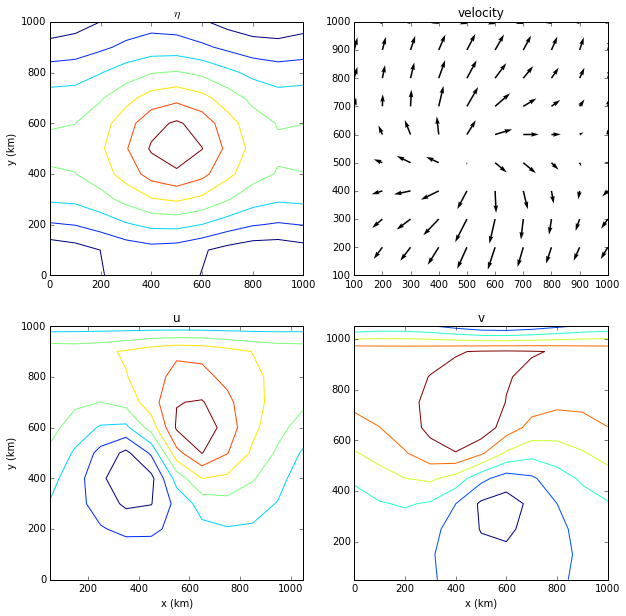

In [56]:
# grid A is grid 1, grid B is grid 2 and and grid C is grid 3
# ngrid is the number of grid points in x and y
# dt is the time step in seconds
# T is the time plotted is seconds to 4*3600 is 4 hours
interactive1.interactive1(grid=3, ngrid=11, dt=150, T=4*3600)

7.2 Accuracy
--------
[accuracy]:(#7.2-Accuracy)

To determine the accuracy of the spatial discretization, we will compare
the *numerical dispersion relation* ([Full Numerical Dispersion Relation](#lab7:eq:full:numDisp)) for
$dt \rightarrow 0$ $$\omega^2 = f^2 + gH \frac {\sin^2(kd)}{d^2} +
gH \frac {\sin^2 (\ell d)}{d^2}$$ with the exact, *continuous dispersion
relation* 
<div id='lab7:eq:full_disp'>
(Full Analytic Dispersion Relation)
$$
\omega^2 = f^2 + gH(k^2+\ell^2)$$
</div>

We can plot the two dispersion relations as functions of $k$ and $\ell$,
given the ratio of $d/R$, where $d$ is the grid size and $R$ is the
Rossby radius defined in the previous section. For example, the exact
$\omega$ and its discrete approximation, using Grid A and $d/R = 1/2$,
can be compared in Figure [Accuracy Comparison](#lab7:fig:accuracy-demo).

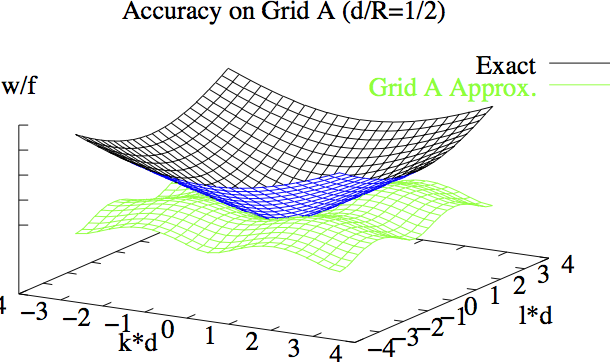

In [57]:
Image(filename='images/accuracy_demo.png',width='60%') 

<div id='lab7:fig:accuracy-demo'>
**Figure Accuracy Comparison:** A comparison of the exact $\omega$ and the discrete approximation
using Grid A and with $d/R=1/2$.
</div>

It is easy to see that the Grid A approximation is not accurate enough.
There are a number of other possibilities for grids, all of which
*stagger* the unknowns; that is, different variables are placed at
different spatial positions as discussed in
section [4.4 Staggered Grids](#4.4-Staggered-Grids).

Below are four which are known as [Mesinger and Arakawa](#MesingerArakawa) B, C, D and E
grids. Note that E is simply a rotation of grid B by $45^\circ$.

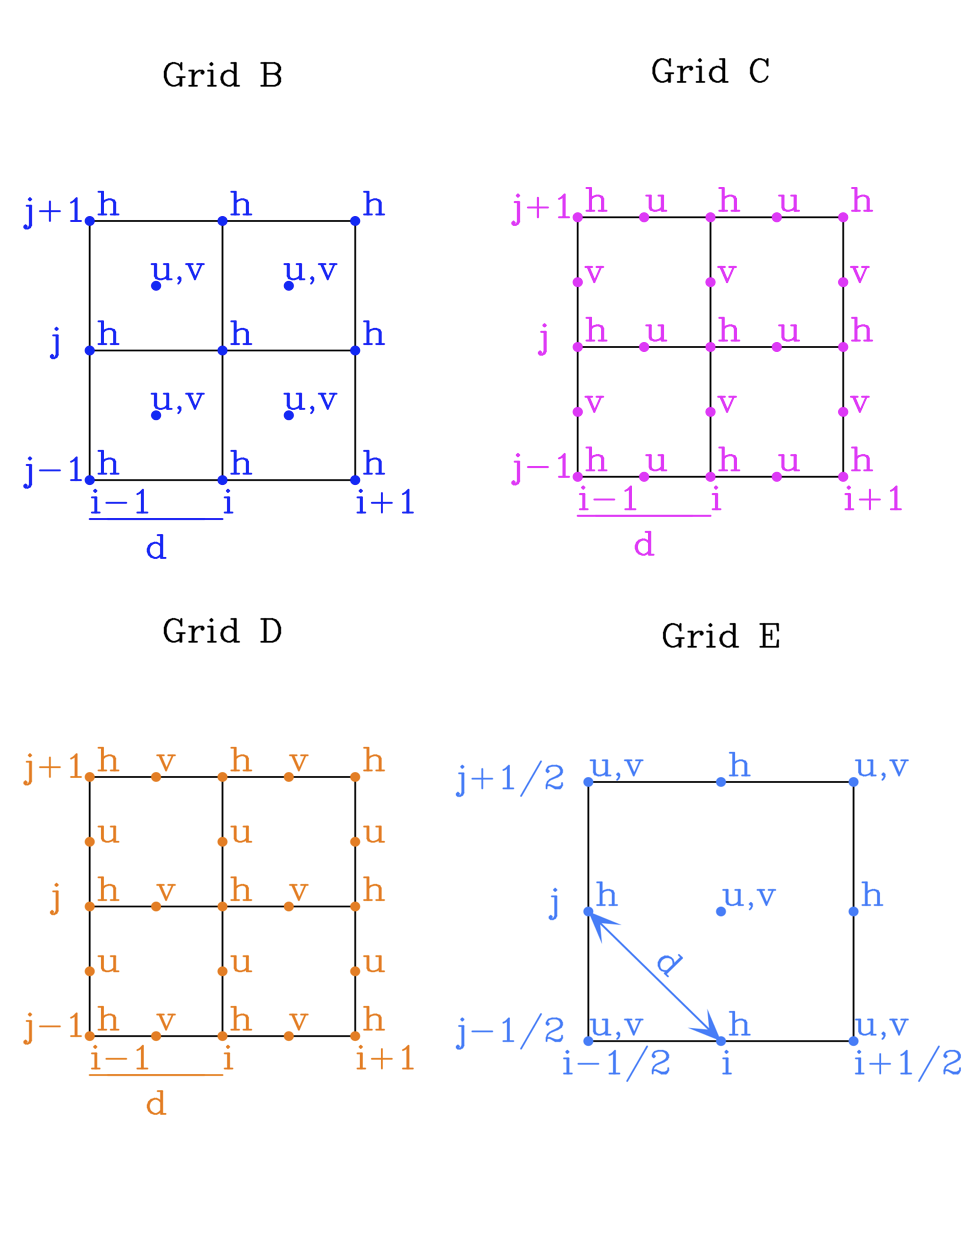

In [58]:
Image(filename='images/fourgrids.png', width='80%')

<div>
**Figure Four More Grids.**
</div>

To work with these grids, we must introduce an averaging operator,
defined in terms of *half-points* on the grid:
$$\overline{\alpha}_{mn}^{x} = \frac{\alpha_{m+\frac{1}{2},n} + \alpha_{m-\frac{1}{2},n}}{2}$$
and modify the difference operator
$$(\delta_{x}\alpha)_{mn} = \frac{\alpha_{m+\frac{1}{2},n} -
  \alpha_{m-\frac{1}{2},n}}{d}$$

*Problem Seven*
--------------
[lab7:prob:finite~d~ifference~f~orm]:(#Problem-Seven)

> A.  For grid B, write down the finite difference form of the shallow
>    water equations.

> B.  For grid C, write down the finite difference form of the shallow
>    water equations.

> C.  For grid D, write down the finite difference form of the shallow
>    water equations.

The dispersion relation for each grid can be found in a manner analgous
to that for the A grid. For the B grid the dispersion relation is
$$\left( \frac {\omega}{f} \right)^2
= 1 + 4 \left( \frac {R}{d} \right)^2 \left( \sin^2 \frac {k d}{2}\cos^2 \frac{\ell d}{2} + \cos^2 \frac {k d}{2}\sin^2 \frac{\ell d}{2} \right)$$
and for the C grid it is $$\left( \frac {\omega}{f} \right)^2
= \cos^2 \frac {k d}{2} \cos^2 \frac{\ell d}{2}  + 4 \left( \frac {R}{d} \right)^2 \left( \sin^2 \frac {k d}{2} + \sin^2 \frac {\ell d}{2} \right)$$

*Problem Eight*
--------------
[lab7:prob:disp~D~]:(#Problem-Eight)

> Find the dispersion relation for the D grid.

> In the interactive exercise below, you will enter the dispersion for
each of the grids. Study each plot carefully for accuracy of phase and
group speed.

In [59]:
def disp_analytic(kd, ld, Rod=0.5):
    Omegaof = 1 + Rod**2 * (kd**2 + ld**2)
    return Omegaof
# define disp_A, disp_B, disp_C here and run the cell

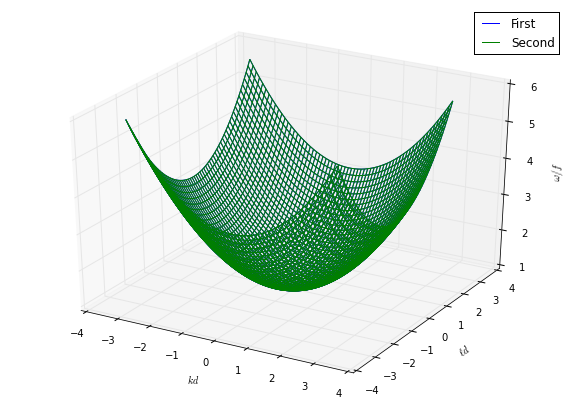

In [60]:
# replace the second disp_analytic with one of your numerical dispersion functions, e.g. disp_A
dispersion_2d.dispersion_2d(disp_analytic, disp_analytic, Rod=0.5)

*Problem Nine*
-------------
[lab7:prob:accuracy]:(#Problem-Nine)

> A.  For $R/d = 2$ which grid gives the most accurate solution?  As well as the closeness of fit of $\omega/f$, also consider the group speed (gradient of the curve).  The group speed is the speed at which wave energy propagates. 

> B.  For $R/d = 0.2$ which grid gives the most accurate solution?  As well as the closeness of fit of $\omega/f$, also consider the group speed (gradient of the curve).  The group speed is the speed at which wave energy propagates. 

8. Details
==========

8.1 Starting the Simulation Full Equations 
-------------------------------------------
[lab7start]:(#8.1-Starting-the-Simulation:-Full-Equations)

The *leap-frog scheme* requires values of $u$, $v$ and $h$ at step 1 as
well as at step 0. However, the initial conditions only provide starting
values at step 0, so we must find some other way to obtain values at
step 1. There are various methods of obtaining the second set of
starting values, and the code used in this laboratory uses a
*predictor/corrector method* to obtain values at step 1 from the values
at step 0. For the simple equations this process was discussed in
section [4.1 Predictor-Corrector to Start](#4.1-Predictor-Corrector-to-Start). For the full equations the procedure goes
as follows:

-   the solution at step $1$ is predicted using a *forward Euler step*:
    $$\begin{array}{l}
      u(1) = u(0) + dt (f v(0)-g \delta_x h(0))\\
      v(1) = v(0) + dt (-f u(0)-g \delta_y h(0))\\
      h(1) = h(0) + dt (-H(\delta_x u(0) + \delta_y v(0))) 
    \end{array}$$

-   then, step $\frac{1}{2}$ is estimated by averaging step $0$ and the
    predicted step $1$: $$\begin{array}{l}  
      u(1/2) = 1/2 (u(0)+u(1)) \\
      v(1/2) = 1/2 (v(0)+v(1)) \\
      h(1/2) = 1/2 (h(0)+h(1)) 
    \end{array}$$

-   finally, the step $1$ approximation is corrected using leap frog
    from $0$ to $1$ (here, we use only a half time-step
    $\frac{1}{2} dt$): $$\begin{array}{l}
      u(1) = u(0) + dt (f v(1/2)-g\delta_x h(1/2)) \\
      v(1) = v(0) + dt(-f u(1/2)-g\delta_y h(1/2)) \\
      h(1) = h(0) + dt(-H (\delta_x u(1/2)+\delta_y v(1/2))) 
    \end{array}$$

8.2 Initialization
------------------

The initial conditions used for the stability demo for the full
equations are Poincare waves as described in the physical example in
Section [3 Physical Example, Poincare Waves](#3.-Physical-Example,-Poincar ́e-Waves).

Assuming a surface height elevation $$h = \cos (kx+\ell y)$$ equations
([Full Eqns, Eqn 1](#lab7:eq:swea),[Full Eqns, Eqn 2](#lab7:eq:sweb)) give $$\begin{aligned}
    u &=& \frac {-1} {H(k^2+\ell^2)} \, \left( k \omega \cos(kx+\ell
      y)+f \ell \sin(kx+\ell y) \right) \nonumber \\
    v &=& \frac 1  {H(k^2+\ell^2)} \, \left( -\ell \omega \cos(kx+\ell
      y)+f k \sin(kx+\ell y)\right) \nonumber \end{aligned}$$ where
$\ell$ and $k$ are selected by the user. It is assumed $g = 9.8$m/s$^2$,
$H = 400$m and $f = 10^{-4}$/s. The value of the frequency $\omega$ is
given by the dispersion relation, ([Full Analytic Dispersion Relation](#lab7:eq:full_disp)).

8.3 Boundary Conditions
----------------------

The boundary conditions used for the stability demo for the full
equations are *“periodic”* in both x and y. Anything which propagates
out the left hand side comes in the right hand side, *etc*. This
condition forces a periodicity on the flow, the wavelengths of the
simulated waves must be sized so that an integral number of waves fits
in the domain.

Specifically, for a $m \times n$ grid, the boundary conditions for the
variable $h$ along the right and left boundaries are $$\begin{aligned}
  h(i=1,j) &=& h(i=m-1,j)\,\,\, {\rm for}\,\,\, j=2 \,\, {\rm to} \,\,n-1\\ \nonumber
  h(i=m,j) &=& h(i=2,j) \,\,\,  {\rm for}\,\,\, j=2 \,\, {\rm to} \,\,n-1
 \end{aligned}$$ and along the top and bottom boundaries
$$\begin{aligned}
  h(i,j=1) &=& h(i,j=n-1)\,\,\, {\rm for} \,\,\, i=2 \,\, {\rm to} \,\,m-1\\ \nonumber
  h(i,j=n) &=& h(i,j=2)  \,\,\, {\rm for} \,\,\, i=2 \,\, {\rm to} \,\,m-1 .
 \end{aligned}$$ The conditions for $u$ and $v$ are identical.

8.4 Computational Mode 
---------------------
[lab7computational_mode]:(#8.4-Computational-Mode)

In section [5. Stability](#5.-Stability) it was determined that there are four
oscillatory modes. Consider letting $dt \rightarrow 0$ in
([Lambda Eqn](#lab7:eq:lambda)). Two of the roots give $+1$ and two roots give $-1$.

Consider the variable $u$ at time $p \, dt$ and one time step later at
time $(p+1) \, dt$.
$$\frac{u_{m(p+1)}}{u_{mp}} = \frac {{\cal R}e \{ {\cal U} \exp [i(kmd - \omega (p+1)\, dt)] \} } {{\cal R}e \{ {\cal U} \exp [i(kmd - \omega p\, dt)] \} } = \exp(i \omega \, dt) = \lambda$$
Thus, $\lambda$ gives the ratio of the velocity at the next time step to
its value at the current time step. Therefore, as the time step gets
very small, physically we expect the system not to change much between
steps. In the limit of zero time step, the value of $u$ or $h$ should
not change between steps; that is $\lambda$ should be $1$.

A value of $\lambda = -1$ implies $u$ changes sign between each step, no
matter how small the step. This mode is not a physical mode of
oscillation, but rather a *computational mode*, which is entirely
non-physical. It arises from using a centre difference scheme in time
and not staggering the grid in time. There are schemes that avoid
introducing such spurious modes (by staggering in time), but we won’t
discuss them here (for more information, see [Mesinger and Arakawa, 1976](#Ref:MesignerArakawa)
[Ch. II]). However, the usual practice in geophysical fluid dynamics is
to use the leap-frog scheme anyway (since it is second order in time)
and find a way to keep the computational modes “small”, in some sense.

For a reasonably small value of $dt$, the computational modes have
$\lambda \approx -1$. Therefore, these modes can be eliminated almost
completely by averaging two adjacent time steps. To understand why this
is so, think of a computational mode $\hat{u}_{mp}$ at time level $p$,
which is added to its counterpart,
$\hat{u}_{m(p+1)} \approx -\hat{u}_{mp}$ at the next time step: *their
sum is approximately zero!* For the code in this lab, it is adequate to
average the solution in this fashion only every 101 time steps (though
larger models may need to be averaged more often). After the averaging
is performed, the code must be restarted; see [Section on Starting](#8.1-Starting-the-Simulation:-Full-Equations).

# Glossary 

**Poincare waves:** These are waves that obey the dispersion relation $\omega ^2=f^2+k^2 c^2$, where $c$ is the wave speed, $k$ is the magnitude of the wavenumber vector, $f$ is the Coriolis frequency, and $\omega $ is the wave frequency.

**CFL condition:** named after Courant, Friedrichs and Levy, who first derived the relationship. This is a stability condition for finite difference schemes (for propagation problems) that corresponds physically to the idea that the continuous domain of dependence must contain the corresponding domain of dependence for the discrete problem.

**dispersive wave:** Any wave whose speed varies with the wavenumber. As a consequence, waves of different wavelengths that start at the same location will move away at different speeds, and hence will spread out, or *disperse*.

**dispersion relation:** For dispersive waves, this relation links the frequency (and hence also the phase speed) to the wavenumber, for a given wave. See also, *dispersive wave*.

**dispersive wave:** Any wave whose speed varies with the wavenumber. As a consequence, waves of different wavelengths that start at the same location will move away at different speeds, and hence will spread out, or *disperse*.

**dispersion relation:** For dispersive waves, this relation links the frequency (and hence also the phase speed) to the wavenumber, for a given wave. See also, *dispersive wave*.

**staggered grid:** This refers to a problem with several unknown functions, where the discrete unknowns are not located at same grid points; rather, they are *staggered* from each other. For example, it is often the case that in addition to the grid points themselves, some uknowns will be placed at the center of grid cells, or at the center of the sides of the grid cells.

**leap-frog scheme:** This term is used to refer to time discretization schemes that use the centered difference formula to discretize the first time derivative in PDE problems. The resulting difference scheme relates the solution at the next time step to the solution *two* time steps previous. Hence, the even- and odd-numbered time steps are linked together, with the resulting computation performed in a *leap-frog* fashion.

**periodic boundary conditions:** Spatial boundary conditions where the value of the solution at one end of the domain is required to be equal to the value on the other end (compare to dirichlet boundary values, where the the solution at both ends is fixed at a specific value or values). This enforces periodicity on the solution, and in terms of a fluid flow problem, these conditions can be thought of more intuitively as requiring that any flow out of the one boundary must return through the corresponding boundary on the other side.

**computational mode:** When performing a modal analysis of a numerical scheme, this is a mode in the solution that does not correspond to any of the "real" (or physical) modes in the continuous problem. It is an artifact of the discretization process only, and can sometimes lead to spurious computational results (for example, with the leap-frog time stepping scheme).

<a name="References"></a>

# References

<a name="Ref:Cushman-Roisin"></a>
Cushman-Roisin, B., 1994: Introduction to Geophysical Fluid Dynamics, Prentice Hall.

<a name="Ref:Gill"></a>
Gill, A.E., 1982: Atmosphere-Ocean Dynamics, Academic Press, Vol. 30 International Geophysics Series, New York. 

<a name="Ref:MesingerArakawa"></a>
Mesinger, F. and A. Arakawa, 1976: Numerical Methods Used in Atmospheric Models,GARP Publications Series No.~17, Global Atmospheric Research Programme.

<a name="Ref:PondPickard"></a>
Pond, G.S. and G.L. Pickard, 1983: Introductory Dynamic Oceanography, Pergamon, Great Britain, 2nd Edition.

<a name="Ref:Pressetal"></a>
Press, W.H., S.A. Teukolsky, W.T. Vetterling and B.P. Flannery, 1992: Numerical Recipes in FORTRAN: The Art of Scientific Computing, Cambridge University Press, Cambridge, 2n Edition.


